In [1]:
import os
import re
import glob
import numpy as np
import cv2
import numba
import py4DSTEM
import hyperspy.api as hs
import matplotlib.pyplot as plt
from IPython.display import Video
from tqdm import tqdm
from ase.io import read
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter, rotate, shift, zoom
from scipy.spatial.transform import Rotation as R
from matplotlib.patches import Rectangle, Circle, Polygon
from matplotlib.path import Path
import matplotlib.patches as patches
import cmasher as cmr

In [2]:
nb_name = 'ROI2-RT-A2'

In [11]:
# 1. Define nb_name and base_path up to Hour_00
base_path = f"F:/1_ARM_BNL_2025-2/250610_FAPbI3_Beam_damage/ROI2-1/{nb_name}/Hour_00"

# 2. Define fixed subfolder: Minute_00/Second_05
target_path = os.path.join(base_path, "Minute_00", "Second_07")

# 3. Find the first .dm4 file in that folder
dm_files = sorted(glob.glob(os.path.join(target_path, "*.dm4")))
if not dm_files:
    raise FileNotFoundError(f"No .dm4 files found in {target_path}")

file_path = dm_files[0].replace("\\", "/")  # Normalize to forward slashes

# 4. Load the image
image_dm = hs.load(file_path)
image = image_dm.data


# 6. Print results
print("nb_name:", nb_name)
print("file_path:", file_path)


nb_name: ROI2-RT-A2
file_path: F:/1_ARM_BNL_2025-2/250610_FAPbI3_Beam_damage/ROI2-1/ROI2-RT-A2/Hour_00/Minute_00/Second_07/ROI2-RT-A2_Hour_00_Minute_00_Second_07_Frame_0000.dm4


In [12]:
# Constants
dose_rate = 30.93 # e/A²s
frames_per_second = 10  # Frames per second
dose_per_frame = dose_rate / frames_per_second  # Dose per frame

In [13]:
# Define scan parameters
scan_size = 700  # Size of the region to scan (500x500 pixels)
square_size = 100  # Size of the square ROI to scan
center_x, center_y = image.shape[1] // 2, image.shape[0] // 2  # Center of the image

# Define the scanning region boundaries
x_min = max(center_x - scan_size // 2, 0)
x_max = min(center_x + scan_size // 2, image.shape[1])
y_min = max(center_y - scan_size // 2, 0)
y_max = min(center_y + scan_size // 2, image.shape[0])

# Initialize variables to store maximum intensity and corresponding center
max_intensity_sum = -1
best_center = (0, 0)

# Scan through the region
for x in range(x_min, x_max - square_size + 1):
    for y in range(y_min, y_max - square_size + 1):
        # Extract the current ROI
        roi_data = image[y:y + square_size, x:x + square_size]
        
        # Calculate the intensity sum
        intensity_sum = np.sum(roi_data)
        
        # Update maximum intensity and best center
        if intensity_sum > max_intensity_sum:
            max_intensity_sum = intensity_sum
            best_center = (x + square_size // 2, y + square_size // 2)

# Save the best center to the `center` variable
center = best_center

image_height = image.shape[0]
image_width = image.shape[1]

# Print the updated center value
print(f"Updated Center: {center}, Max Intensity Sum: {max_intensity_sum:.2f}")


Updated Center: (1762, 1707), Max Intensity Sum: 195477.00


crystal system 'cubic' is not interpreted for space group Spacegroup(221, setting=1). This may result in wrong setting!
This Atoms object contains occupancy information but it will be ignored.
Scale: 100%|██████████| 11/11 [05:38<00:00, 30.81s/it]


✅ 최적 파라미터:
  center_x: 34.00
  center_y: -21.00
  rotation_angle: 31.00
  scale: 1.0600
  blur_sigma: 10
  Max correlation: 0.1302


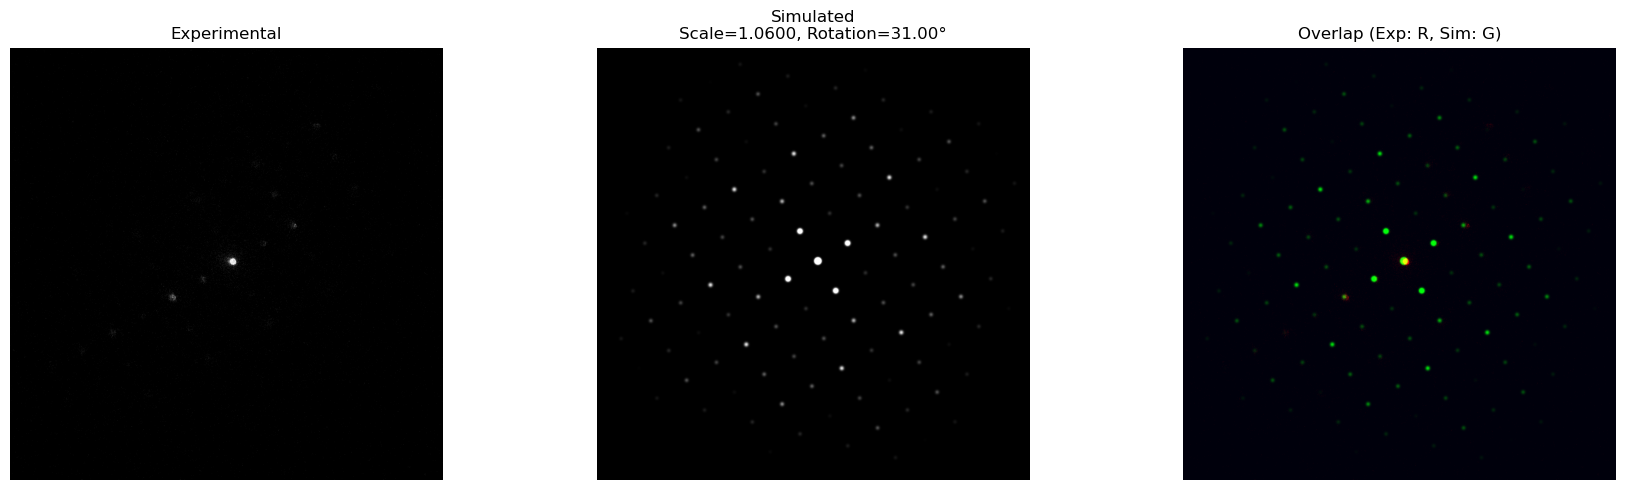

In [14]:
# ── 고정 파라미터 설정 ─────────────────────────────────────────────
blur_sigma = 10
center_x = center[0] - image_width / 2
center_y = center[1] - image_height / 2

# ── 결정 구조 및 시뮬레이션 패턴 생성 ──────────────────────────────
ZA = np.array([0, 0, 1])
crystal = py4DSTEM.process.diffraction.Crystal.from_ase(read('C:/structure/Cubic_Pm-3m.cif'))
crystal.calculate_dynamical_structure_factors(accelerating_voltage=200e3, method='Lobato')
dp = crystal.generate_diffraction_pattern(zone_axis_lattice=ZA, sigma_excitation_error=0.02)
pattern = crystal.generate_dynamical_diffraction_pattern(beams=dp, thickness=400, zone_axis_lattice=ZA)

# ── 2D 시뮬레이션 패턴 구성 ──────────────────────────────────────
M = image.shape[0]
qx, qy, intensity = pattern.data['qx'], pattern.data['qy'], pattern.data['intensity']
kx_max = max(abs(qx).max(), abs(qy).max()) * 1.1
pixel_scale = kx_max * 2 / M
pattern_2d = np.zeros((M, M))

for qxi, qyi, inten in zip(qx, qy, intensity):
    px = int((qxi + kx_max) / pixel_scale)
    py = int((qyi + kx_max) / pixel_scale)
    if 0 <= px < M and 0 <= py < M:
        pattern_2d[py, px] += inten

# ── Cross-correlation function ─────────────────────────────────────
def compute_normalized_cross_correlation(img1, img2):
    img1 = img1 - np.mean(img1)
    img2 = img2 - np.mean(img2)
    numerator = np.sum(img1 * img2)
    denominator = np.sqrt(np.sum(img1 ** 2) * np.sum(img2 ** 2))
    return numerator / denominator if denominator != 0 else 0

def simulate_log_pattern(scale, rotation_angle, blur_sigma, center_x, center_y):
    sim = gaussian_filter(pattern_2d, sigma=blur_sigma)
    sim = zoom(sim, scale, order=1)
    sim = rotate(sim, rotation_angle, reshape=False, order=1)

    sy, sx = sim.shape
    if (sy, sx) != (M, M):
        if sy >= M and sx >= M:
            start_y = (sy - M) // 2
            start_x = (sx - M) // 2
            sim = sim[start_y:start_y+M, start_x:start_x+M]
        else:
            padded = np.zeros((M, M))
            pad_y = (M - sy) // 2
            pad_x = (M - sx) // 2
            padded[pad_y:pad_y+sy, pad_x:pad_x+sx] = sim
            sim = padded

    sim = shift(sim, [center_y, center_x], order=1, mode='constant', cval=0)
    sim /= sim.max() if sim.max() > 0 else 1
    sim_log = np.clip(np.log1p(sim * 50), 0, 1)
    return sim_log

# ── Preprocess experimental image ──────────────────────────────────
exp = image.astype(np.float32)
exp /= exp.max() if exp.max() > 0 else 1
exp_log = np.clip(np.log1p(exp * 50), 0, 1)

# ── Grid search to find best parameters ────────────────────────────
rotation_default = 30
scale_default = 1.05
best_score = -np.inf
best_params = (scale_default, rotation_default)

scale_range = np.round(np.linspace(scale_default - 0.05, scale_default + 0.05, 11), 4)
angle_range = np.arange(rotation_default - 2.5, rotation_default + 2.5 + 0.1, 0.5)

for scale in tqdm(scale_range, desc="Scale"):
    for angle in angle_range:
        sim_log = simulate_log_pattern(scale, angle, blur_sigma, center_x, center_y)
        score = compute_normalized_cross_correlation(exp_log, sim_log)
        if score > best_score:
            best_score = score
            best_params = (scale, angle)

scale, rotation_angle = best_params

# ── 시각화 함수 ─────────────────────────────────────────────────
def plot_patterns(scale, blur_sigma):
    brightness = 50.0
    sim = gaussian_filter(pattern_2d, sigma=blur_sigma)
    sim = zoom(sim, scale, order=1)
    sim = rotate(sim, rotation_angle, reshape=False, order=1)

    sy, sx = sim.shape
    if (sy, sx) != (M, M):
        if sy >= M and sx >= M:
            start_y = (sy - M) // 2
            start_x = (sx - M) // 2
            sim = sim[start_y:start_y+M, start_x:start_x+M]
        else:
            padded = np.zeros((M, M))
            pad_y = (M - sy) // 2
            pad_x = (M - sx) // 2
            padded[pad_y:pad_y+sy, pad_x:pad_x+sx] = sim
            sim = padded

    sim = shift(sim, [center_y, center_x], order=1, mode='constant', cval=0)
    sim /= sim.max() if sim.max() > 0 else 1
    sim_log = np.clip(np.log1p(sim * brightness), 0, 1)

    exp_log = np.clip(np.log1p(exp * brightness), 0, 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].imshow(exp_log, cmap='gray')
    axes[0].set_title('Experimental')
    axes[0].axis('off')

    axes[1].imshow(sim_log, cmap='gray')
    axes[1].set_title(f'Simulated\nScale={scale:.4f}, Rotation={rotation_angle:.2f}°')
    axes[1].axis('off')

    overlap = np.stack([
        exp_log ** 0.5,
        sim_log,
        np.full_like(exp_log, 0.05)
    ], axis=-1)
    axes[2].imshow(np.clip(overlap, 0, 1))
    axes[2].set_title('Overlap (Exp: R, Sim: G)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# ── 결과 출력 ─────────────────────────────────────────────────────
print("✅ 최적 파라미터:")
print(f"  center_x: {center_x:.2f}")
print(f"  center_y: {center_y:.2f}")
print(f"  rotation_angle: {rotation_angle:.2f}")
print(f"  scale: {scale:.4f}")
print(f"  blur_sigma: {blur_sigma}")
print(f"  Max correlation: {best_score:.4f}")

plot_patterns(scale, blur_sigma)


✅ Optimal spacing: 278 pixels (based on PbI₂ intensity)


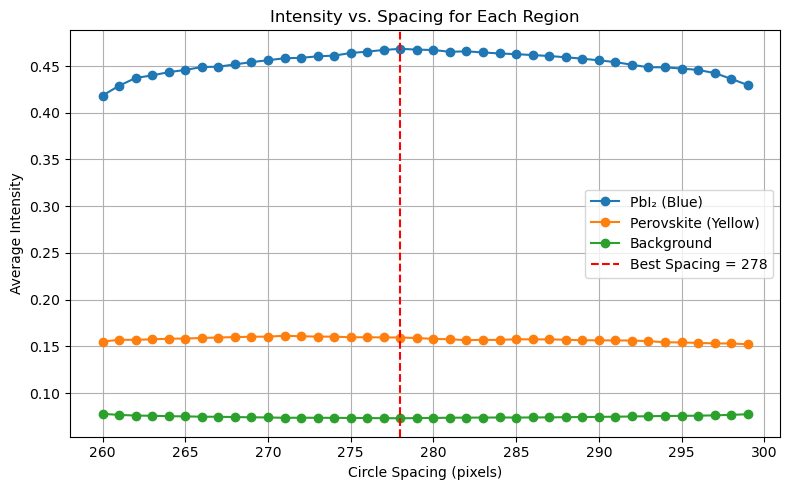

Average PbI2 Intensity: 0.47
Average Perov Intensity: 0.16
Average Center Intensity: 3.21
Average Background Intensity: 0.07
Intensity Difference (Yellow - Background): 0.09


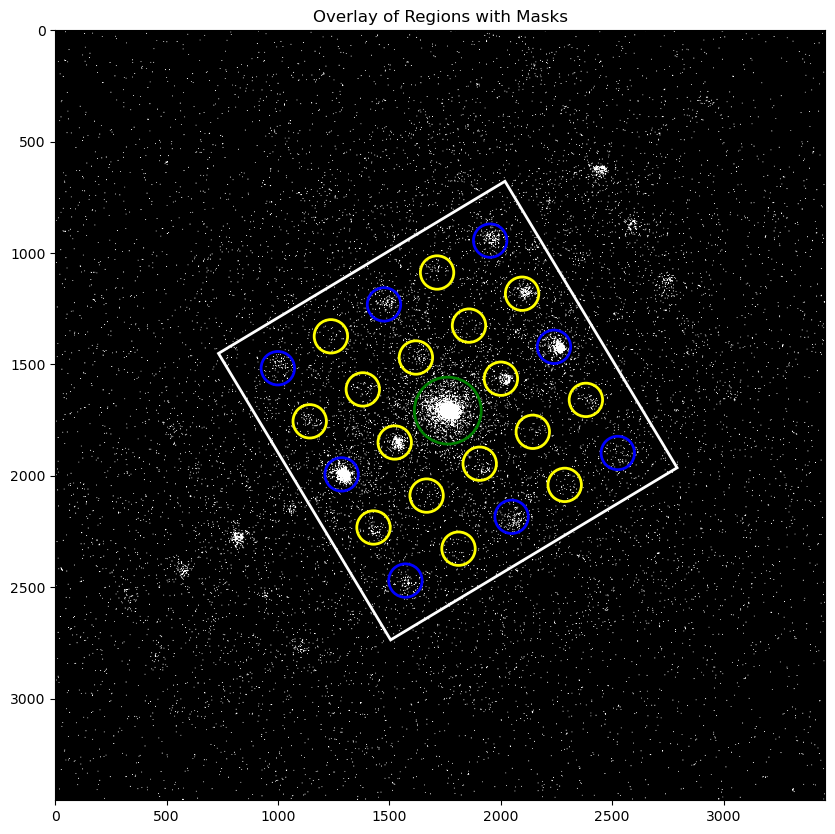

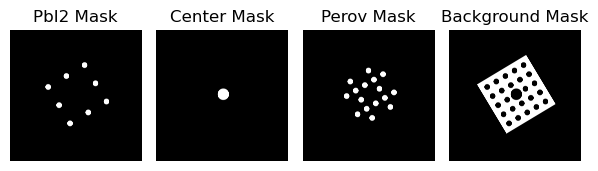

In [20]:
# Ensure image is single-channel (e.g., grayscale)
if image.ndim == 3:
    image = image[:, :, 0]

# Define image dimensions and parameters
rect_side = 1500
rect_angle = -rotation_angle # degrees
circle_diameter = 150
center_circle_diameter = 300
image_height, image_width = image.shape

# Helper function to rotate points around the center
def rotate_point(x, y, cx, cy, angle):
    rad = np.radians(angle)
    x_rot = np.cos(rad) * (x - cx) - np.sin(rad) * (y - cy) + cx
    y_rot = np.sin(rad) * (x - cx) + np.cos(rad) * (y - cy) + cy
    return x_rot, y_rot

# ─── Optimize spacing based on PbI2 intensity ───
spacing_values = np.arange(260, 300, 1)
avg_intensities_PbI2 = []
avg_intensities_Perov = []
avg_intensities_Center = []
avg_intensities_Background = []

PbI2_indices = [0, 4, 20, 24, 2, 10, 14, 22]
Center_index = 12

for test_spacing in spacing_values:
    circle_positions = []
    for i in range(-2, 3):
        for j in range(-2, 3):
            x = center[0] + j * test_spacing
            y = center[1] + i * test_spacing
            circle_positions.append((x, y))
    rotated_circle_positions = [rotate_point(x, y, center[0], center[1], rect_angle) for x, y in circle_positions]

    PbI2_positions = [rotated_circle_positions[idx] for idx in PbI2_indices]
    Perov_positions = [rotated_circle_positions[idx] for idx in range(25) if idx not in PbI2_indices + [Center_index]]
    Center_position = rotated_circle_positions[Center_index]

    mask_PbI2 = np.zeros((image_height, image_width), dtype=bool)
    mask_Perov = np.zeros((image_height, image_width), dtype=bool)
    mask_Center = np.zeros((image_height, image_width), dtype=bool)
    mask_total = np.zeros((image_height, image_width), dtype=bool)

    rr, cc = np.ogrid[:image_height, :image_width]
    for pos in PbI2_positions:
        mask_PbI2 |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2
    for pos in Perov_positions:
        mask_Perov |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2
    mask_Center |= (rr - Center_position[1]) ** 2 + (cc - Center_position[0]) ** 2 <= (center_circle_diameter / 2) ** 2

    rect_corners = [
        rotate_point(center[0] - rect_side / 2, center[1] - rect_side / 2, center[0], center[1], rect_angle),
        rotate_point(center[0] + rect_side / 2, center[1] - rect_side / 2, center[0], center[1], rect_angle),
        rotate_point(center[0] + rect_side / 2, center[1] + rect_side / 2, center[0], center[1], rect_angle),
        rotate_point(center[0] - rect_side / 2, center[1] + rect_side / 2, center[0], center[1], rect_angle),
    ]
    rect_path = Path(rect_corners)
    xx, yy = np.meshgrid(np.arange(image_width), np.arange(image_height))
    points = np.vstack((xx.ravel(), yy.ravel())).T
    rect_mask_rotated = rect_path.contains_points(points).reshape(image.shape)

    mask_total = mask_PbI2 | mask_Perov | mask_Center
    mask_background = rect_mask_rotated & ~mask_total

    avg_intensities_PbI2.append(np.mean(image[mask_PbI2]))
    avg_intensities_Perov.append(np.mean(image[mask_Perov]))
    avg_intensities_Center.append(np.mean(image[mask_Center]))
    avg_intensities_Background.append(np.mean(image[mask_background]))

optimal_index = np.argmax(avg_intensities_PbI2)
spacing = spacing_values[optimal_index]
print(f"\u2705 Optimal spacing: {spacing} pixels (based on PbI\u2082 intensity)")

# Plot intensity vs. spacing
plt.figure(figsize=(8, 5))
plt.plot(spacing_values, avg_intensities_PbI2, label='PbI\u2082 (Blue)', marker='o')
plt.plot(spacing_values, avg_intensities_Perov, label='Perovskite (Yellow)', marker='o')
plt.plot(spacing_values, avg_intensities_Background, label='Background', marker='o')
plt.axvline(spacing, color='red', linestyle='--', label=f'Best Spacing = {spacing}')
plt.xlabel("Circle Spacing (pixels)")
plt.ylabel("Average Intensity")
plt.title("Intensity vs. Spacing for Each Region")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── Visualize masks using the optimal spacing ───
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap='gray', vmax=2)

circle_positions = []
for i in range(-2, 3):
    for j in range(-2, 3):
        x = center[0] + j * spacing
        y = center[1] + i * spacing
        circle_positions.append((x, y))
rotated_circle_positions = [rotate_point(x, y, center[0], center[1], rect_angle) for x, y in circle_positions]

PbI2_positions = [rotated_circle_positions[idx] for idx in PbI2_indices]
Perov_positions = [rotated_circle_positions[idx] for idx in range(25) if idx not in PbI2_indices + [Center_index]]
center_positions = [rotated_circle_positions[Center_index]]

def draw_circle(ax, center, diameter, color, **kwargs):
    circle = Circle((center[0], center[1]), diameter / 2, edgecolor=color, facecolor='none', linewidth=2, **kwargs)
    ax.add_patch(circle)

for pos in rotated_circle_positions:
    if pos in PbI2_positions:
        draw_circle(ax, pos, circle_diameter, 'blue')
    elif pos in center_positions:
        draw_circle(ax, pos, center_circle_diameter, 'green')
    elif pos in Perov_positions:
        draw_circle(ax, pos, circle_diameter, 'yellow')

rect_origin = (
    center[0] - rect_side / 2 * np.cos(np.radians(rect_angle)) + rect_side / 2 * np.sin(np.radians(rect_angle)),
    center[1] - rect_side / 2 * np.sin(np.radians(rect_angle)) - rect_side / 2 * np.cos(np.radians(rect_angle))
)
rect = Rectangle(
    rect_origin,
    rect_side,
    rect_side,
    angle=rect_angle,
    linewidth=2,
    edgecolor='white',
    facecolor='none'
)
ax.add_patch(rect)

# Recompute masks with optimal spacing
mask_total = np.zeros_like(image, dtype=bool)
mask_PbI2 = np.zeros_like(image, dtype=bool)
mask_Center = np.zeros_like(image, dtype=bool)
mask_Perov = np.zeros_like(image, dtype=bool)

rr, cc = np.ogrid[:image_height, :image_width]
for pos in rotated_circle_positions:
    if pos in PbI2_positions:
        mask_PbI2 |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2
    elif pos in center_positions:
        mask_Center |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (center_circle_diameter / 2) ** 2
    elif pos in Perov_positions:
        mask_Perov |= (rr - pos[1]) ** 2 + (cc - pos[0]) ** 2 <= (circle_diameter / 2) ** 2

rect_path = Path(rect_corners)
xx, yy = np.meshgrid(np.arange(image_width), np.arange(image_height))
points = np.vstack((xx.ravel(), yy.ravel())).T
rect_mask_rotated = rect_path.contains_points(points).reshape(image.shape)

mask_total |= mask_Perov | mask_PbI2 | mask_Center
mask_background = rect_mask_rotated & ~mask_total

# Display intensities
avg_PbI2_intensity = np.mean(image[mask_PbI2])
avg_Perov_intensity = np.mean(image[mask_Perov])
avg_Center_intensity = np.mean(image[mask_Center])
avg_background_intensity = np.mean(image[mask_background])

print(f"Average PbI2 Intensity: {avg_PbI2_intensity:.2f}")
print(f"Average Perov Intensity: {avg_Perov_intensity:.2f}")
print(f"Average Center Intensity: {avg_Center_intensity:.2f}")
print(f"Average Background Intensity: {avg_background_intensity:.2f}")
print(f"Intensity Difference (Yellow - Background): {avg_Perov_intensity - avg_background_intensity:.2f}")

ax.set_xlim(0, image_width)
ax.set_ylim(image_height, 0)
ax.set_title("Overlay of Regions with Masks")
plt.show()

# Show all masks
fig, axes = plt.subplots(1, 4, figsize=(6, 2))
masks = [mask_PbI2, mask_Center, mask_Perov, mask_background]
titles = ["PbI2 Mask", "Center Mask", "Perov Mask", "Background Mask"]

for ax, mask, title in zip(axes, masks, titles):
    ax.imshow(mask, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:

image_list = []

# Find the total number of Minute directories
minute_dirs = [d for d in sorted(os.listdir(base_path)) if d.startswith("Minute_")]
end_of_min = len(minute_dirs)

# Iterate over the Minute directories (Minute_00, Minute_01, ...)
for min_idx, min_dir_name in enumerate(minute_dirs):
    min_dir = os.path.join(base_path, min_dir_name)
    
    # Find the total number of Second directories in the current Minute directory
    second_dirs = [d for d in sorted(os.listdir(min_dir)) if d.startswith("Second_")]
    end_of_sec = len(second_dirs)
    
    # Iterate over the Second directories (Second_00, Second_01, ...)
    for sec_idx, second_dir_name in enumerate(second_dirs):
        second_dir = os.path.join(min_dir, second_dir_name)
        
        # Get all the .dm4 files in the directory
        dm4_files = [f for f in sorted(os.listdir(second_dir)) if f.endswith(".dm4")]
        
        # Iterate through each .dm4 file
        for file_name in dm4_files:
            file_path = os.path.join(second_dir, file_name)
            
            # Load the .dm4 file using hyperspy
            image_dm = hs.load(file_path)  # Use hs.load() from hyperspy.api
            image_data = image_dm.data

            # Keep the original pixel values (no normalization)
            image_data_3d = cv2.cvtColor(image_data.astype(np.uint8), cv2.COLOR_GRAY2BGR)
            
            # Append the image data to the stack
            image_list.append(image_data_3d)

print(f"Processed {len(image_list)} images from {end_of_min} Minute directories and their Second subdirectories.")


Processed 223 images from 1 Minute directories and their Second subdirectories.


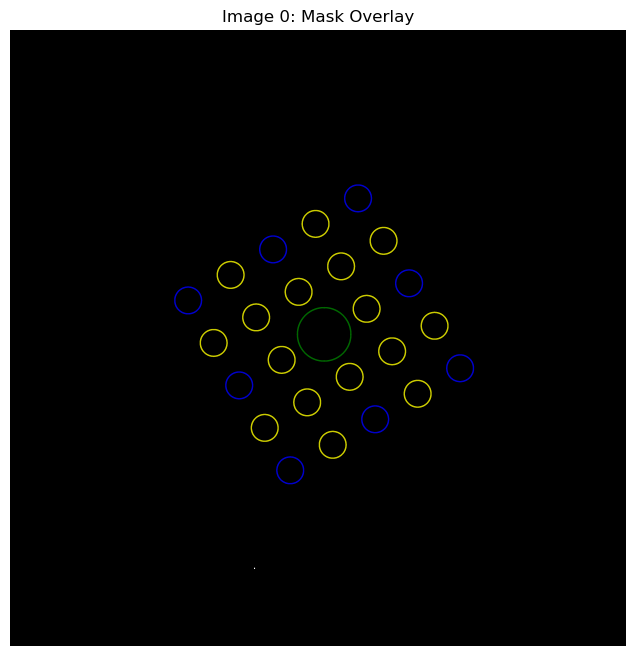

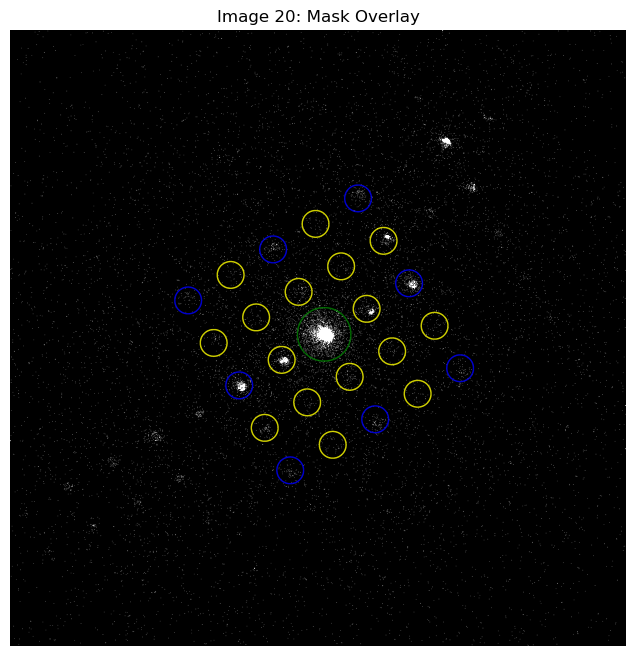

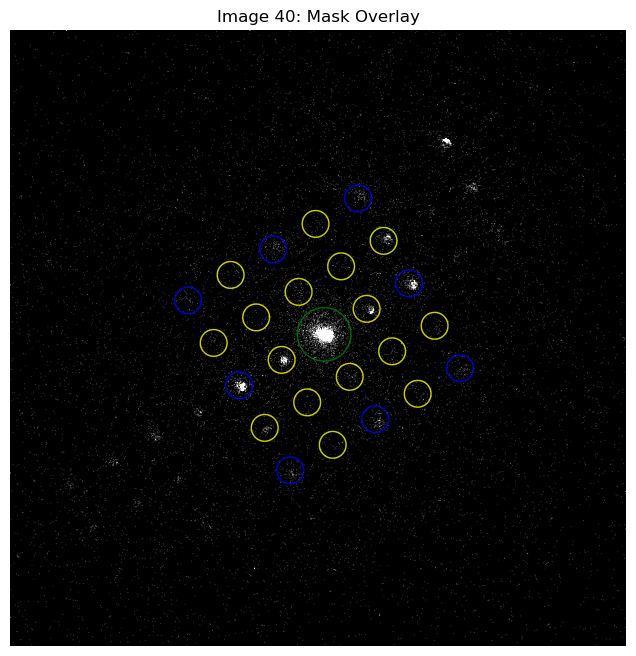

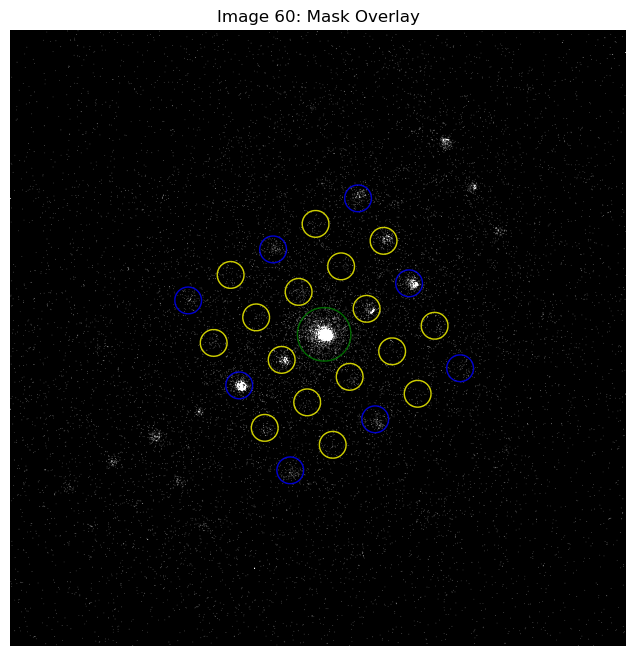

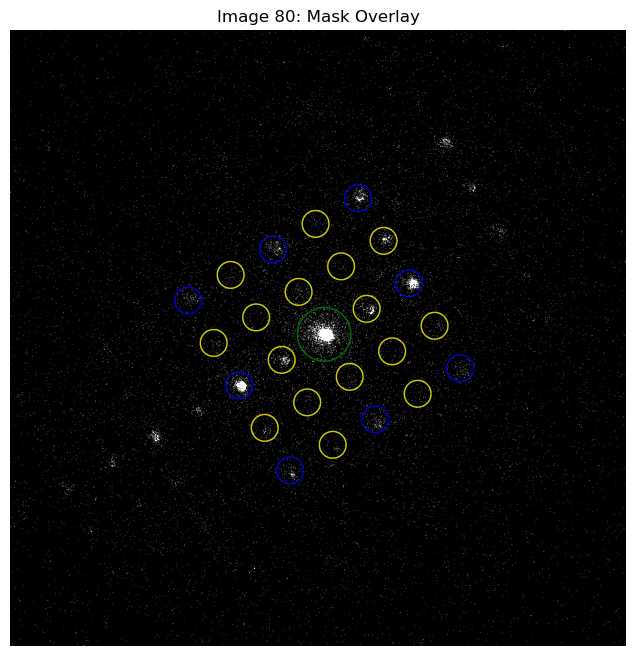

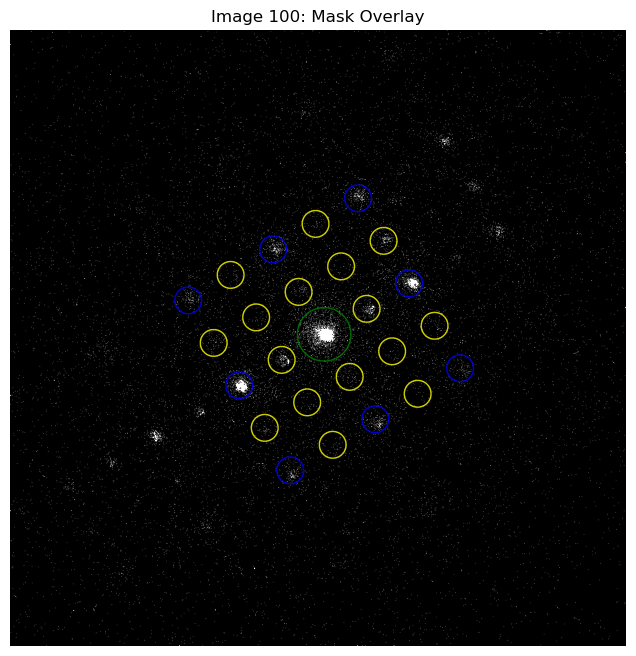

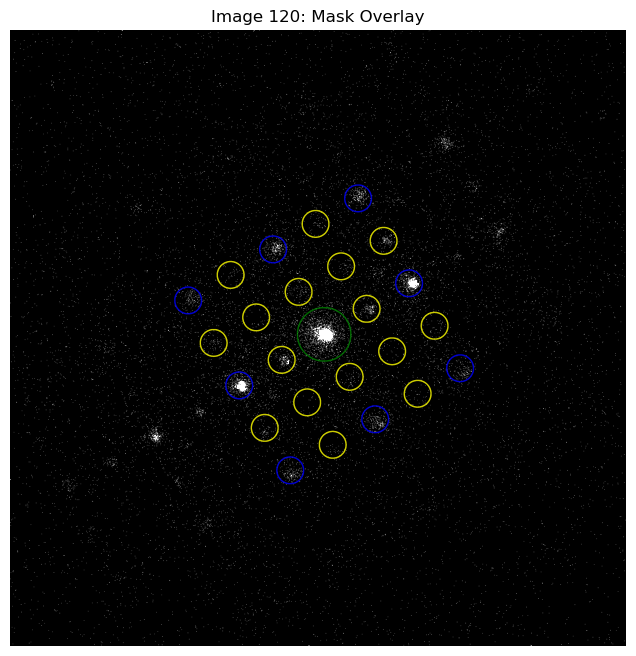

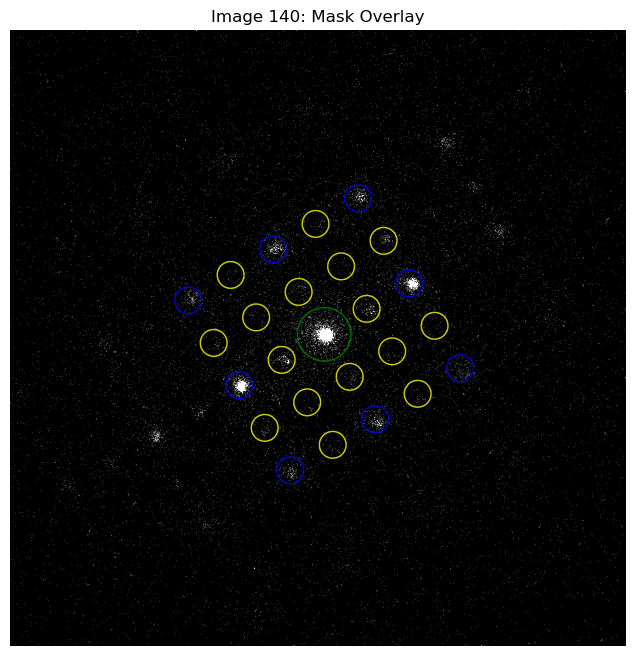

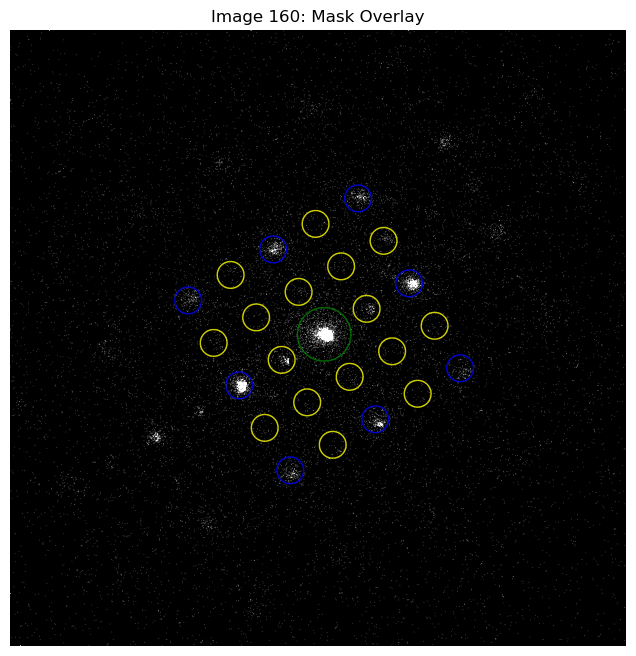

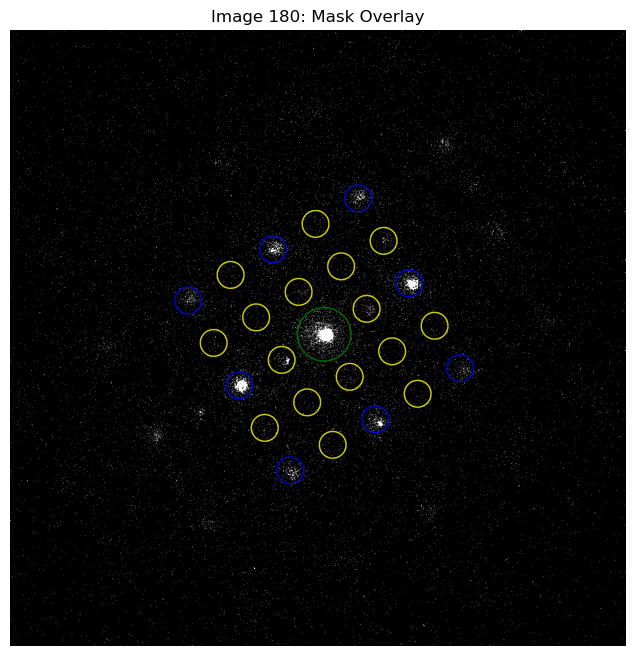

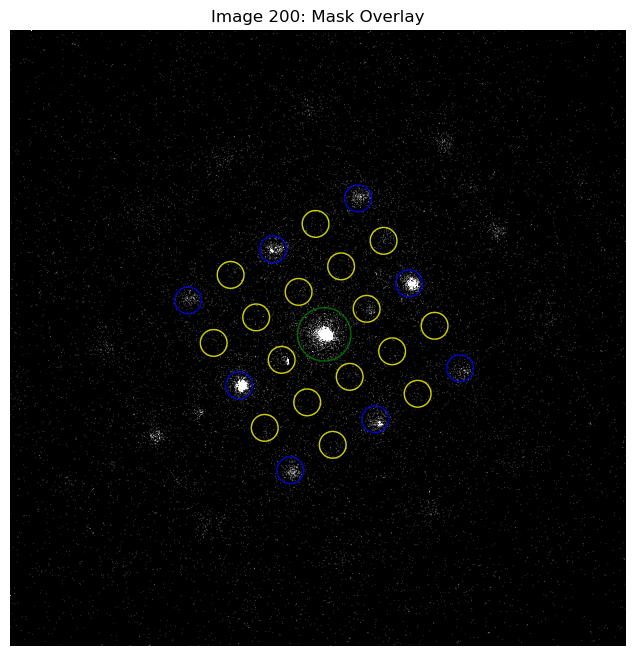

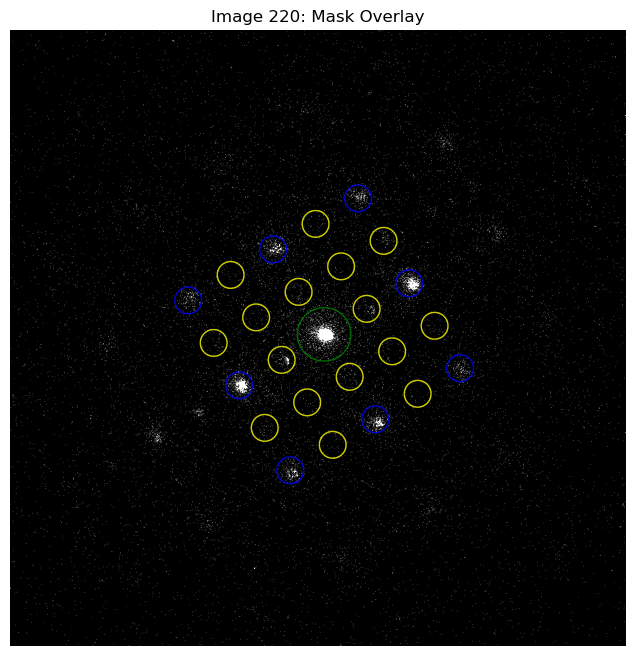

In [22]:
# Intensity differences 저장 리스트
PbI2_list = []
Perov_list = []
Center_list = []
background_list = []
difference_list = []
#radial_list = []

# 각 이미지에서 intensity difference 계산
for idx, image in enumerate(image_list):
    # 이미지를 그레이스케일로 변환 (NumPy 연산 활용)
    gray_image = np.dot(image[..., :3], [0.2989, 0.587, 0.114]).astype(np.float32)
    
    # Intensity 계산
    avg_PbI2_intensity = np.mean(gray_image[mask_PbI2])
    avg_Perov_intensity = np.mean(gray_image[mask_Perov])
    avg_Center_intensity = np.mean(gray_image[mask_Center])
    avg_background_intensity = np.mean(gray_image[mask_background])
    intensity_diff = avg_Perov_intensity - avg_background_intensity
    


    PbI2_list.append(avg_PbI2_intensity)
    Perov_list.append(avg_Perov_intensity)
    Center_list.append(avg_Center_intensity)
    background_list.append(avg_background_intensity)
    difference_list.append(intensity_diff)

    # 20장마다 마스크와 겹친 이미지 플롯
    if idx % 20 == 0:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(gray_image, cmap='gray', vmax=5)
        ax.contour(mask_PbI2, colors='blue', linewidths=1, alpha=0.8)
        ax.contour(mask_Perov, colors='yellow', linewidths=1, alpha=0.8)
        ax.contour(mask_Center, colors='green', linewidths=1, alpha=0.8)
        ax.set_title(f"Image {idx}: Mask Overlay")
        ax.axis('off')
        plt.show()



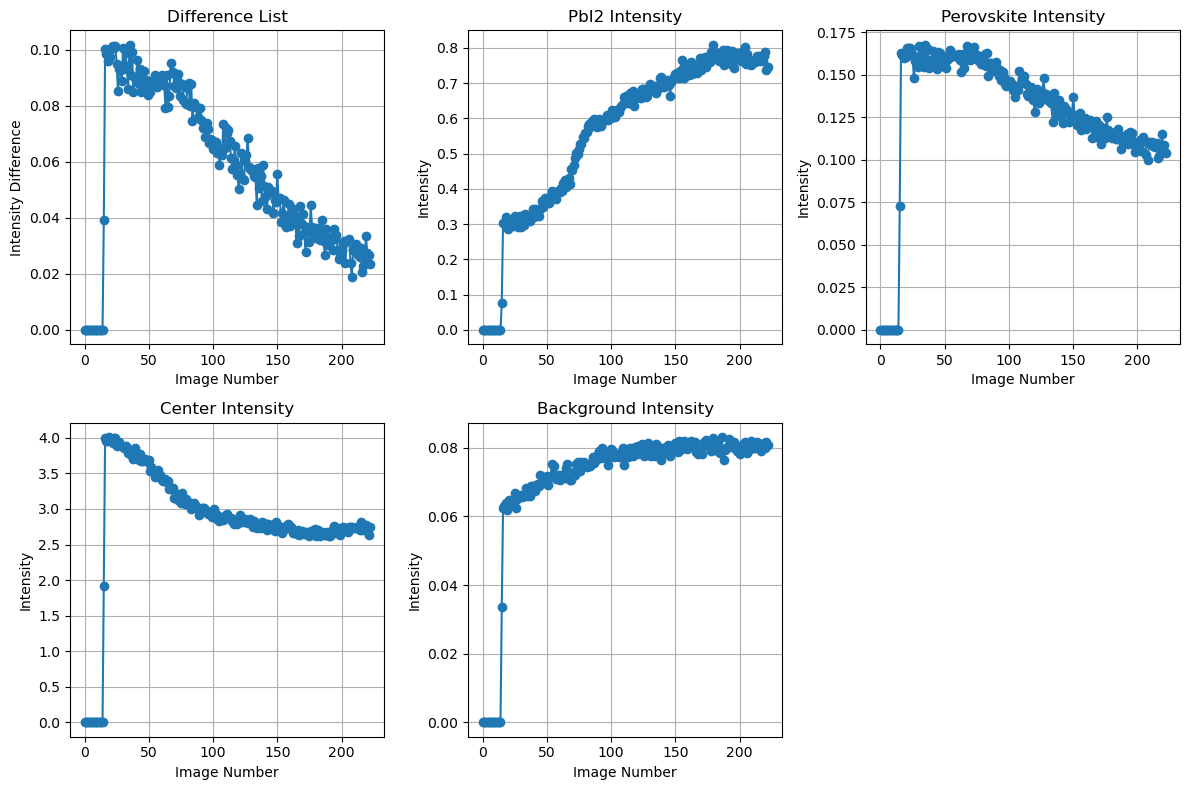

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plotting the data in a 2x3 grid
axes[0, 0].plot(range(len(difference_list)), difference_list, marker='o')
axes[0, 0].set_title("Difference List")
axes[0, 0].set_xlabel("Image Number")
axes[0, 0].set_ylabel("Intensity Difference")
axes[0, 0].grid()

axes[0, 1].plot(range(len(PbI2_list)), PbI2_list, marker='o')
axes[0, 1].set_title("PbI2 Intensity")
axes[0, 1].set_xlabel("Image Number")
axes[0, 1].set_ylabel("Intensity")
axes[0, 1].grid()

axes[0, 2].plot(range(len(Perov_list)), Perov_list, marker='o')
axes[0, 2].set_title("Perovskite Intensity")
axes[0, 2].set_xlabel("Image Number")
axes[0, 2].set_ylabel("Intensity")
axes[0, 2].grid()

axes[1, 0].plot(range(len(Center_list)), Center_list, marker='o')
axes[1, 0].set_title("Center Intensity")
axes[1, 0].set_xlabel("Image Number")
axes[1, 0].set_ylabel("Intensity")
axes[1, 0].grid()

axes[1, 1].plot(range(len(background_list)), background_list, marker='o')
axes[1, 1].set_title("Background Intensity")
axes[1, 1].set_xlabel("Image Number")
axes[1, 1].set_ylabel("Intensity")
axes[1, 1].grid()

# Hide the last subplot (empty one)
axes[1, 2].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [24]:
# 1. 최대값 찾기
# Ensure y_data is defined
y_data = np.array(difference_list)  # Assuming y_data corresponds to difference_list
y_max = np.max(y_data)

# 2. y_max의 몇 % 이상에서 시작할 것인지 정함 (예: 90%)
threshold_ratio = 0.9
threshold_value = y_max * threshold_ratio

# 3. threshold 이상 중 첫 번째 index (즉, 감소 시작점 이전의 최대값 근처)
start_index = np.argmax(y_data >= threshold_value)

# 4. 이후 처리는 동일
cumulative_dose = np.arange(len(y_data)) * dose_per_frame

if start_index < len(cumulative_dose):
    cumulative_dose = cumulative_dose[start_index:] - cumulative_dose[start_index]
    difference_list_adjusted = y_data[start_index:]
    PbI2_list_adjusted = np.array(PbI2_list[start_index:])
    Perov_list_adjusted = np.array(Perov_list[start_index:])
    Center_list_adjusted = np.array(Center_list[start_index:])
    background_list_adjusted = np.array(background_list[start_index:])
else:
    # fallback: 아무 변화 없음
    difference_list_adjusted = y_data
    PbI2_list_adjusted = np.array(PbI2_list)
    Perov_list_adjusted = np.array(Perov_list)
    Center_list_adjusted = np.array(Center_list)
    background_list_adjusted = np.array(background_list)

# 길이 정렬
min_length = min(len(cumulative_dose), 
                 len(difference_list_adjusted), 
                 len(PbI2_list_adjusted), 
                 len(Perov_list_adjusted), 
                 len(Center_list_adjusted), 
                 len(background_list_adjusted))

cumulative_dose = cumulative_dose[:min_length]
difference_list_adjusted = difference_list_adjusted[:min_length]
PbI2_list_adjusted = PbI2_list_adjusted[:min_length]
Perov_list_adjusted = Perov_list_adjusted[:min_length]
Center_list_adjusted = Center_list_adjusted[:min_length]
background_list_adjusted = background_list_adjusted[:min_length]




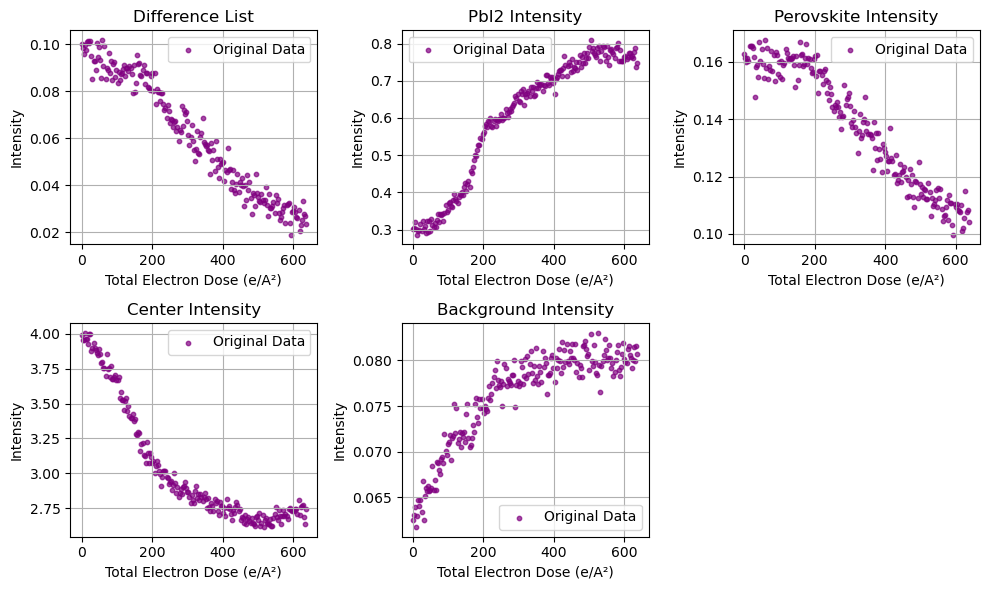

In [25]:
# List of datasets and titles
data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

# Plotting in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.ravel()  # Flatten the axes array for easier indexing

for i, (data, title) in enumerate(data_lists):
    axes[i].scatter(cumulative_dose, data, label="Original Data", color="purple", alpha=0.7, s=10)
    axes[i].set_title(title)
    axes[i].set_xlabel("Total Electron Dose (e/A²)")
    axes[i].set_ylabel("Intensity")
    axes[i].grid()
    axes[i].legend()

# Hide the empty subplot if any
if len(data_lists) < len(axes):
    axes[-1].axis("off")

plt.tight_layout()
plt.show()


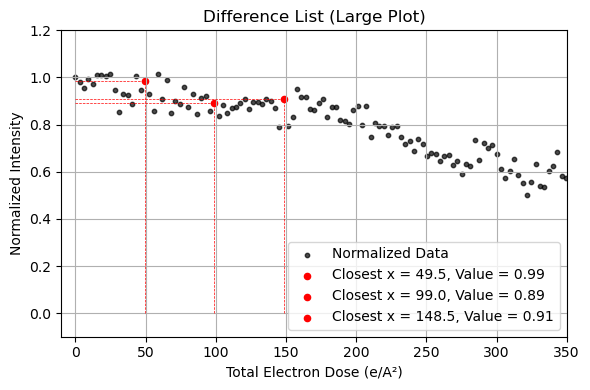

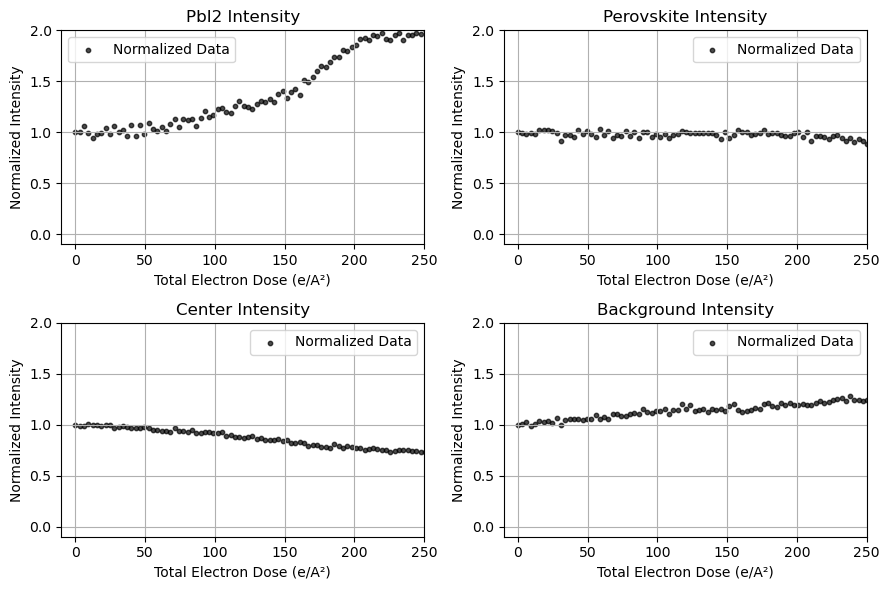

In [26]:
from matplotlib.lines import Line2D

# List of datasets and titles
data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

# Function to normalize data
def normalize(data):
    first_val = data[0]  # 첫 번째 값
    return [val / first_val for val in data]

# Function to find the closest index for a given value
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

# Plotting for Difference List (large plot)
fig_diff, ax_diff = plt.subplots(figsize=(6, 4))
normalized_diff = normalize(difference_list_adjusted)  # Normalize Difference List
ax_diff.scatter(cumulative_dose, normalized_diff, label="Normalized Data", color="black", alpha=0.7, s=10)
ax_diff.set_title("Difference List (Large Plot)")
ax_diff.set_xlabel("Total Electron Dose (e/A²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)  # Set y-axis limits
ax_diff.set_xlim(-10,350)
ax_diff.grid()

# Highlight specific points for Difference List plot
for dose in [50, 100, 150]:
    idx = find_closest_index(cumulative_dose, dose)  # Find the index of the closest dose
    x, y = cumulative_dose[idx], normalized_diff[idx]  # Get (x, y) coordinates
    ax_diff.scatter(x, y, color="red", s=20, label=f"Closest x = {x:.1f}, Value = {y:.2f}")  # Highlight point
    
    # Add lines to x and y axes only
    line_x = Line2D([x, x], [0, y], color="red", linestyle="--", linewidth=0.5)  # Vertical line to x-axis
    line_y = Line2D([0, x], [y, y], color="red", linestyle="--", linewidth=0.5)  # Horizontal line to y-axis
    ax_diff.add_line(line_x)
    ax_diff.add_line(line_y)

ax_diff.legend()  # Add legend to Difference List plot
plt.tight_layout()
plt.show()

# Plotting for other datasets (2x2 grid)
fig_others, axes_others = plt.subplots(2, 2, figsize=(9, 6))
axes_others = axes_others.ravel()  # Flatten the axes array for easier indexing

for i, (data, title) in enumerate(data_lists[1:]):  # Skip the first dataset (Difference List)
    normalized_data = normalize(data)  # Normalize the data
    axes_others[i].scatter(cumulative_dose, normalized_data, label="Normalized Data", color="black", alpha=0.7, s=10)
    axes_others[i].set_title(title)
    axes_others[i].set_xlabel("Total Electron Dose (e/A²)")
    axes_others[i].set_ylabel("Normalized Intensity")
    axes_others[i].set_ylim(-0.1, 2.0)  # Set x-axis limits 
    axes_others[i].set_xlim(-10, 250)  # Set x-axis limits
    axes_others[i].grid()
    axes_others[i].legend()

# Hide the empty subplot if any
if len(data_lists[1:]) < len(axes_others):
    axes_others[-1].axis("off")

plt.tight_layout()
plt.show()

In [27]:
# --- 1단계: start_index 이후부터 이미지 사용 ---
filtered_images = image_list[start_index:]

# --- 2단계: 프레임 수 계산 (기존 정의된 dose_per_frame 사용) ---
frames_per_set = int(50 / dose_per_frame)  # 50 e/Å²마다 합칠 프레임 수
num_sets = len(filtered_images) // frames_per_set

# --- 3단계: 이미지 합치기 ---
summed_images = np.array([
    np.sum(filtered_images[i * frames_per_set:(i + 1) * frames_per_set], axis=0)
    for i in range(num_sets)
])

# --- 4단계: RGB인 경우 grayscale로 변환 (선택사항) ---
if summed_images.ndim == 4 and summed_images.shape[-1] == 3:
    summed_images = np.mean(summed_images, axis=-1)

# --- 5단계: 감마 보정 ---
gamma = 0.01
summed_images = summed_images ** gamma
dose_values = np.array([dose_per_frame * frames_per_set * (i + 1) for i in range(num_sets)])
# # --- 6단계: 시각화 ---
# dose_values = np.array([50 * (i + 1) for i in range(num_sets)])

# for i, img in enumerate(summed_images):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(img, cmap='gray')
#     plt.axis("off")
#     plt.text(10, 20, f"{dose_values[i]:.1f} e/Å²", color='red', fontsize=12, weight='bold',
#              bbox=dict(facecolor='white', alpha=0.7))
#     plt.show()


crystal system 'cubic' is not interpreted for space group Spacegroup(221, setting=1). This may result in wrong setting!
This Atoms object contains occupancy information but it will be ignored.
100%|██████████| 841/841 [39:11<00:00,  2.80s/it]


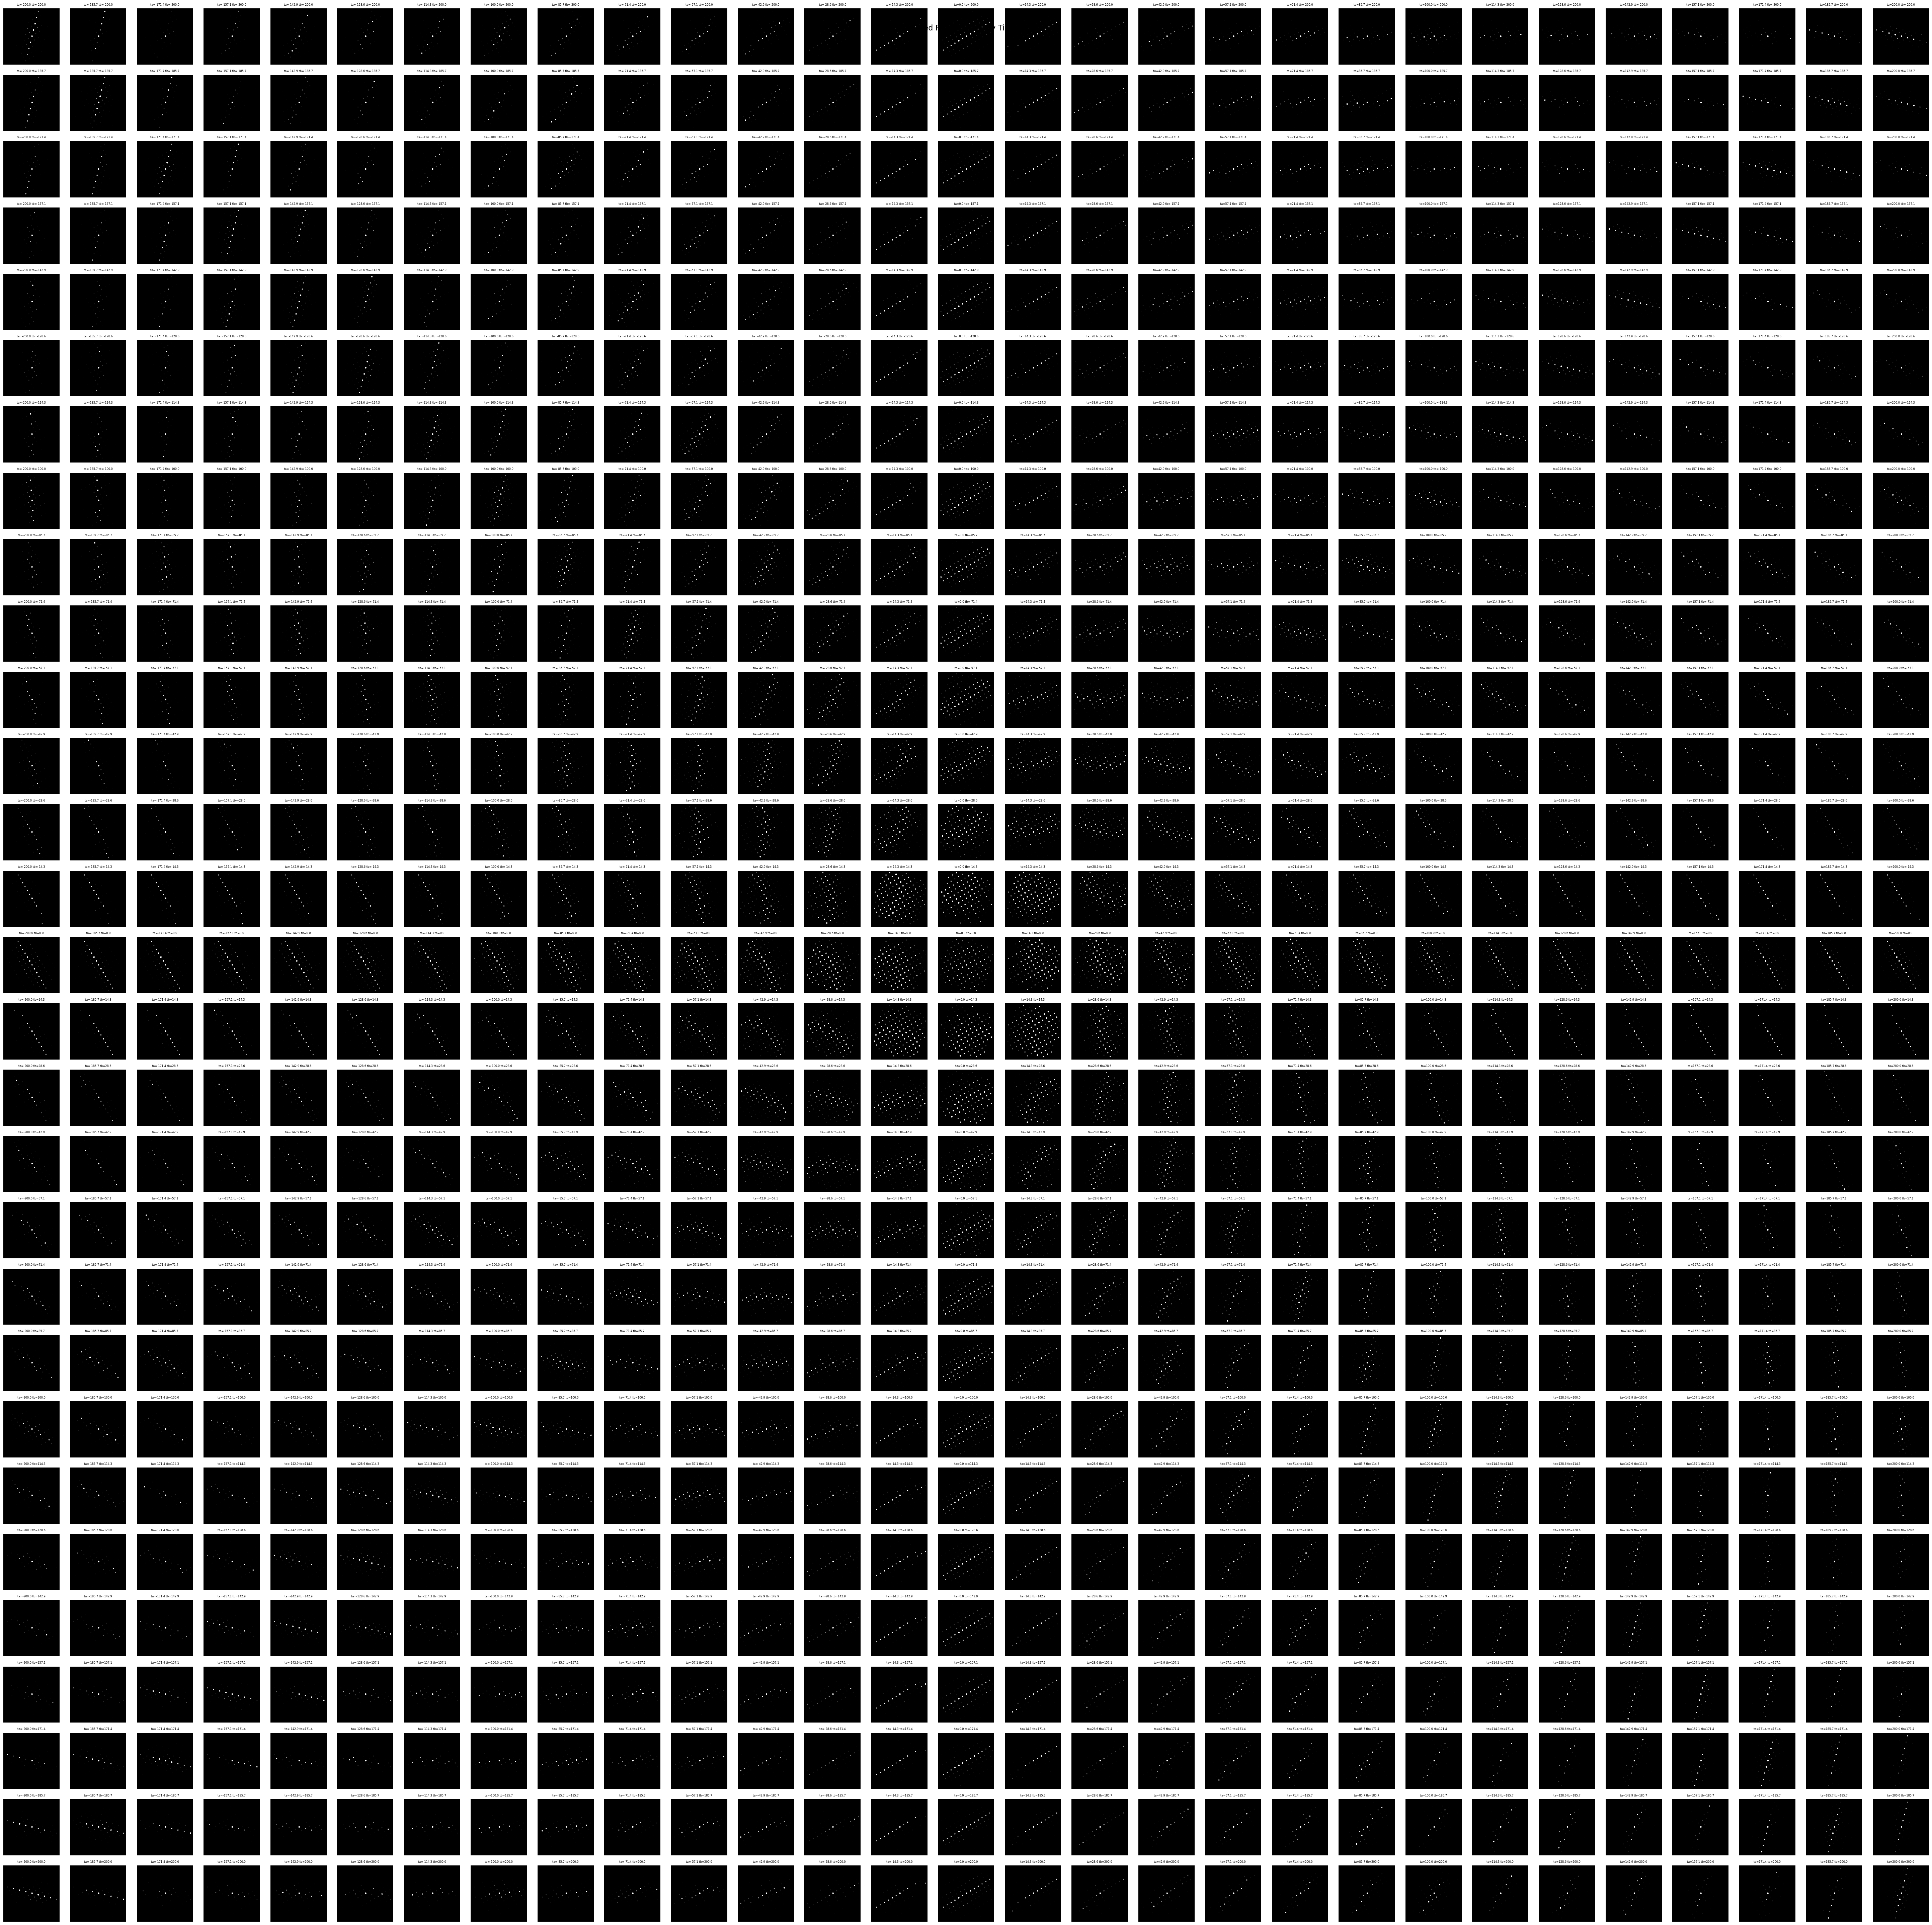

✅ Image saved to: c:\Users\bgil\OneDrive - Brookhaven National Laboratory\Desktop\Beam damage\250610_Beam_Damage\2-1\DP-mistilts\ROI2-RT-A2.png


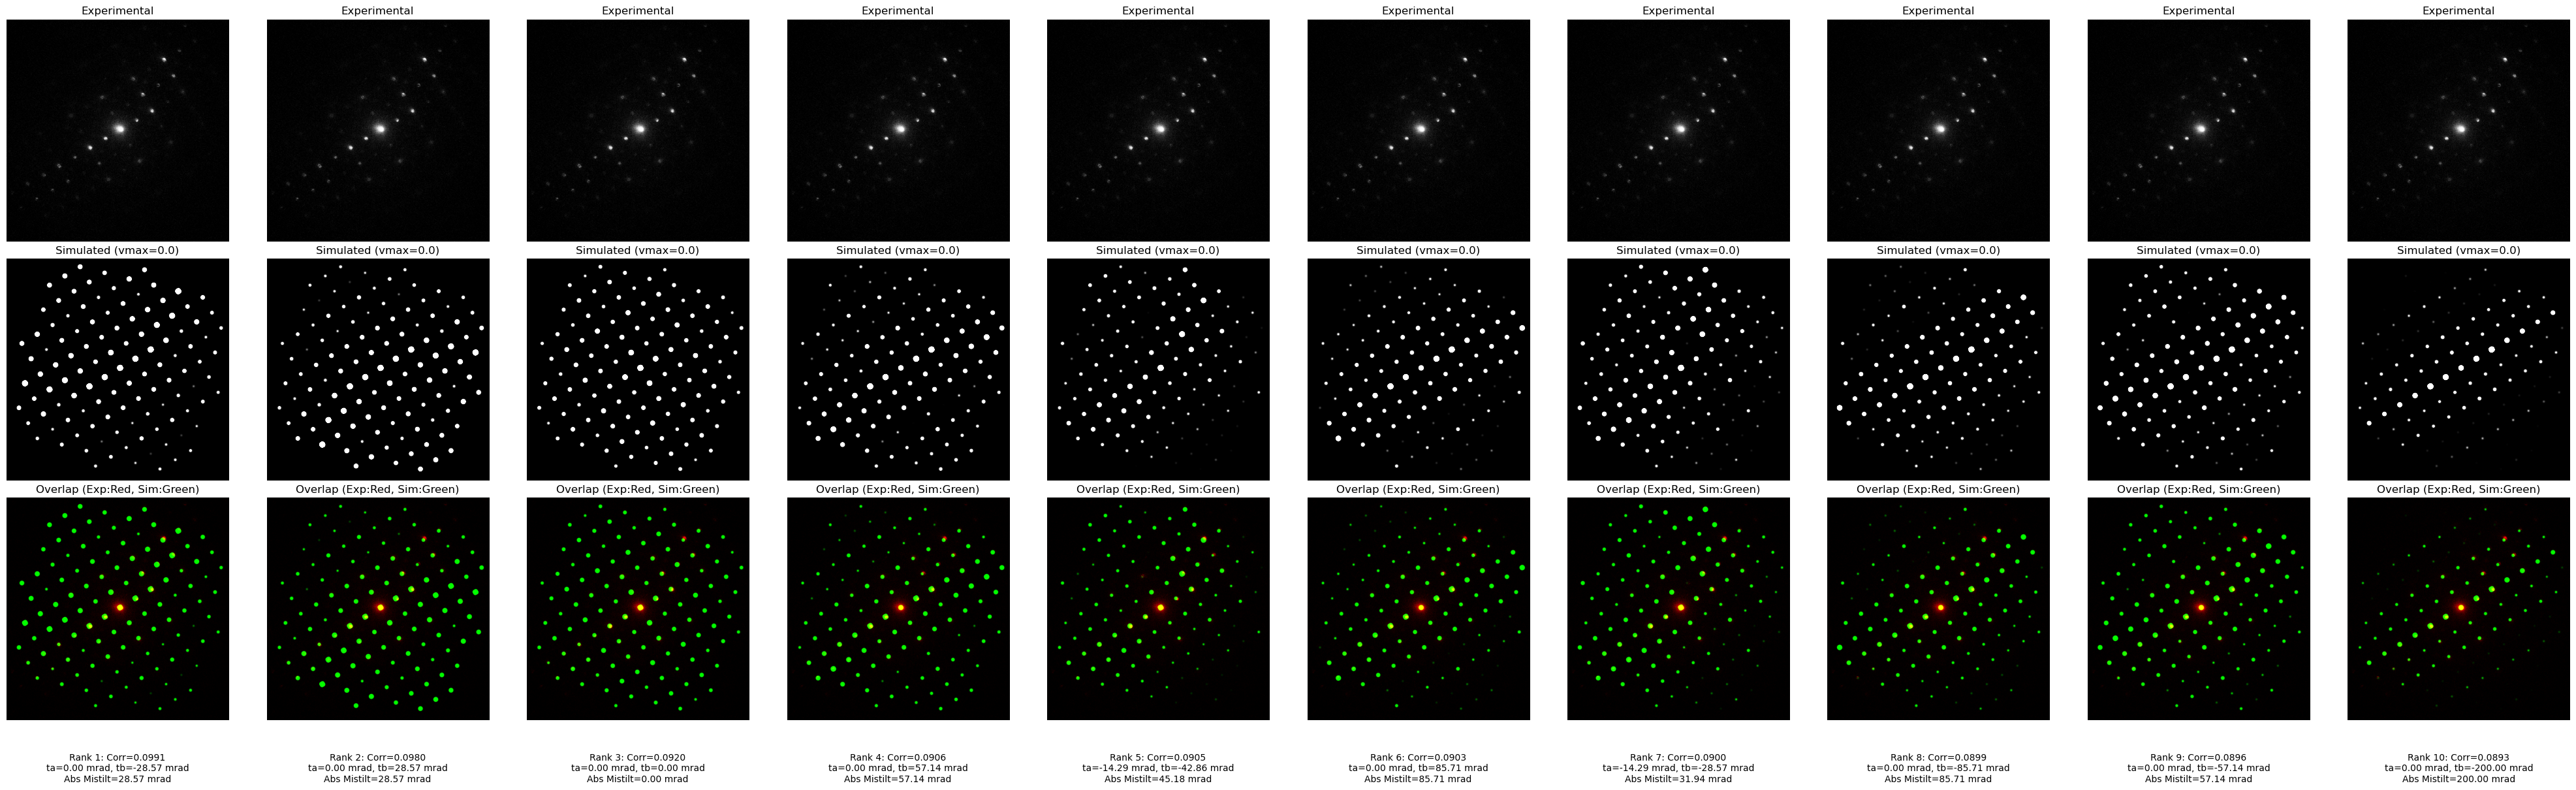

In [32]:
# ─── 실험 회절 이미지 ───────────────────────────────────────
diffraction_image = summed_images[0]
M = diffraction_image.shape[0]

# ─── 결정 구조 및 빔 ───────────────────────────────────────
crystal = py4DSTEM.process.diffraction.Crystal.from_ase(read('C:/structure/Cubic_Pm-3m.cif'))
crystal.calculate_dynamical_structure_factors(accelerating_voltage=200e3, method='Lobato')
dp1 = crystal.generate_diffraction_pattern(zone_axis_lattice=[0, 0, 1], sigma_excitation_error=0.02)

# ─── 틸트 매트릭스 설정 ─────────────────────────────────────
rot_axis_a = np.array([0., 1., 0.])
rot_axis_b = np.array([-1., 0., 0.])
rot_axis_a /= np.linalg.norm(rot_axis_a)
rot_axis_b /= np.linalg.norm(rot_axis_b)

rot_a = 180  # mrad
rot_b = 180  # mrad
N_tilt = 21  # Can be changed freely
thickness_compare = 400

tilt_a, tilt_b = np.meshgrid(
    np.linspace(-rot_a, rot_a, N_tilt),
    np.linspace(-rot_b, rot_b, N_tilt)
)

simulated_patterns = np.zeros((N_tilt, N_tilt, M, M))

# ─── 메인 루프 ──────────────────────────────────────────────
for idx in tqdm(range(N_tilt * N_tilt)):
    i, j = divmod(idx, N_tilt)
    ta, tb = float(tilt_a.flat[idx]), float(tilt_b.flat[idx])

    Ra = R.from_rotvec((ta / 1000.0) * rot_axis_a)
    Rb = R.from_rotvec((tb / 1000.0) * rot_axis_b)
    tilted_ZA = (Ra * Rb).apply([0, 0, 1])

    pattern = crystal.generate_dynamical_diffraction_pattern(
        beams=dp1,
        thickness=thickness_compare,
        zone_axis_lattice=tilted_ZA
    )

    qx, qy, I = pattern.data['qx'], pattern.data['qy'], pattern.data['intensity']
    kx_max = max(abs(qx.min()), qx.max()) * 1.1
    ky_max = max(abs(qy.min()), qy.max()) * 1.1
    pixel_scale = 2 * kx_max / M

    pat2d = np.zeros((M, M))
    for qxi, qyi, Ii in zip(qx, qy, I):
        px = int((qxi + kx_max) / pixel_scale)
        py = int((qyi + ky_max) / pixel_scale)
        if 0 <= px < M and 0 <= py < M:
            pat2d[py, px] += Ii

    if not pat2d.any():
        continue

    pat2d = gaussian_filter(pat2d, sigma=blur_sigma)
    pat2d = zoom(pat2d, scale, order=1)
    pat2d = rotate(pat2d, rotation_angle, reshape=False, order=1)

    sy, sx = pat2d.shape
    if sy >= M and sx >= M:
        start_y, start_x = (sy - M) // 2, (sx - M) // 2
        pat2d = pat2d[start_y:start_y+M, start_x:start_x+M]
    else:
        padded = np.zeros((M, M))
        pad_y, pad_x = (M - sy) // 2, (M - sx) // 2
        padded[pad_y:pad_y+sy, pad_x:pad_x+sx] = pat2d
        pat2d = padded

    pat2d = shift(pat2d, shift=[center_y, center_x], order=1, mode='constant', cval=0)

    maxv = pat2d.max()
    if maxv > 0:
        pat2d *= diffraction_image.max() * 100 / maxv  # Brighten up

    simulated_patterns[i, j] = pat2d

# ─── 시뮬레이션 패턴 전체 시각화 (Grid) ──────────────────────
fig, axes = plt.subplots(N_tilt, N_tilt, figsize=(2*N_tilt, 2*N_tilt))
for i in range(N_tilt):
    for j in range(N_tilt):
        ax = axes[i, j]
        ax.imshow(simulated_patterns[i, j], cmap='gray', vmax=0.1)
        ax.set_title(f"ta={tilt_a[i,j]:.1f} tb={tilt_b[i,j]:.1f}", fontsize=6)
        ax.axis('off')
plt.suptitle("Simulated Patterns Grid by Tilt Angles", fontsize=16)
plt.tight_layout()
plt.show()

# ─── 결과 저장 및 상관계수 ─────────────────────────────────
np.save('simulated_patterns.npy', simulated_patterns)

exp_flat = diffraction_image.flatten()
sim_flat = simulated_patterns.reshape(N_tilt, N_tilt, -1)
correlations = np.zeros((N_tilt, N_tilt))

for ii in range(N_tilt):
    for jj in range(N_tilt):
        correlations[ii, jj] = np.nan_to_num(np.corrcoef(exp_flat, sim_flat[ii, jj])[0, 1])

flat_idx = np.argsort(correlations.ravel())[::-1]
top_k = min(10, len(flat_idx))
top_i, top_j = np.unravel_index(flat_idx[:top_k], correlations.shape)

# ─── 시각화 및 저장 (Top-k) ──────────────────────────────────────
max_exp = diffraction_image.max()
vmax_sim = max_exp / 100

fig, axes = plt.subplots(3, top_k, figsize=(4*top_k, 12))

for k in range(top_k):
    si, sj = top_i[k], top_j[k]
    sim = simulated_patterns[si, sj]

    ta_best = tilt_a[si, sj]
    tb_best = tilt_b[si, sj]
    absolute_mistilt = np.sqrt(ta_best**2 + tb_best**2)
    mistilt_text = (f"Rank {k+1}: Corr={correlations[si,sj]:.4f}\n"
                    f"ta={ta_best:.2f} mrad, tb={tb_best:.2f} mrad\n"
                    f"Abs Mistilt={absolute_mistilt:.2f} mrad")

    # Row 1: Experimental
    axes[0, k].imshow(diffraction_image, cmap='gray', vmin=0, vmax=max_exp)
    axes[0, k].set_title('Experimental')
    axes[0, k].axis('off')
    axes[0, k].set_xlabel(mistilt_text, fontsize=8, wrap=True)

    # Row 2: Simulated
    axes[1, k].imshow(sim, cmap='gray', vmin=0, vmax=vmax_sim)
    axes[1, k].set_title(f'Simulated (vmax={vmax_sim:.1f})')
    axes[1, k].axis('off')
    axes[1, k].set_xlabel(mistilt_text, fontsize=8, wrap=True)

    # Row 3: Overlap
    ov = np.zeros((M, M, 3))
    ov[..., 0] = diffraction_image / max_exp
    ov[..., 1] = np.clip(sim / vmax_sim, 0, 1)
    axes[2, k].imshow(ov)
    axes[2, k].set_title('Overlap (Exp:Red, Sim:Green)')
    axes[2, k].axis('off')
    axes[2, k].text(0.5, -0.15, mistilt_text, fontsize=10,
                    ha='center', va='top', transform=axes[2, k].transAxes)

plt.tight_layout()

output_dir = os.path.join(os.getcwd(), 'DP-mistilts')
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, f"{nb_name}.png")
plt.savefig(save_path, dpi=300)
print(f"✅ Image saved to: {save_path}")

plt.show()


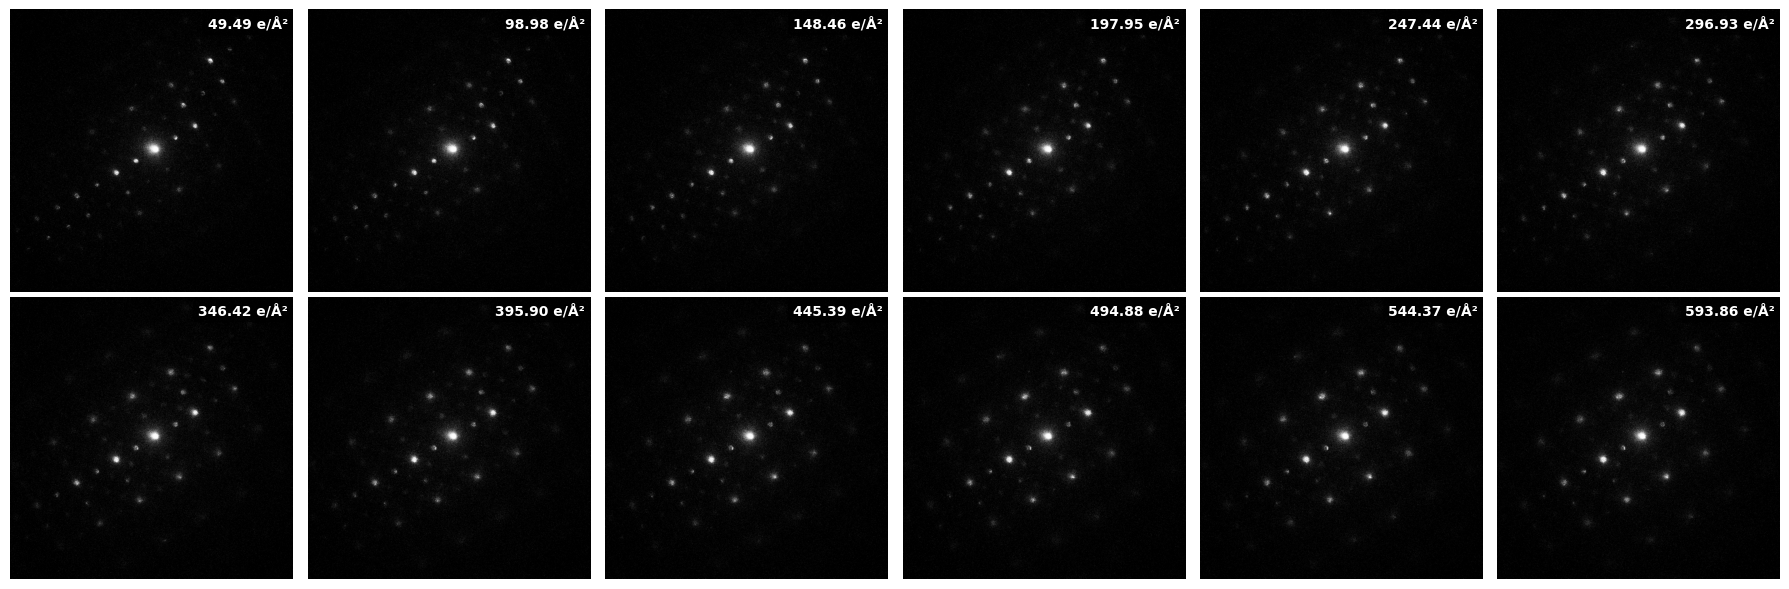

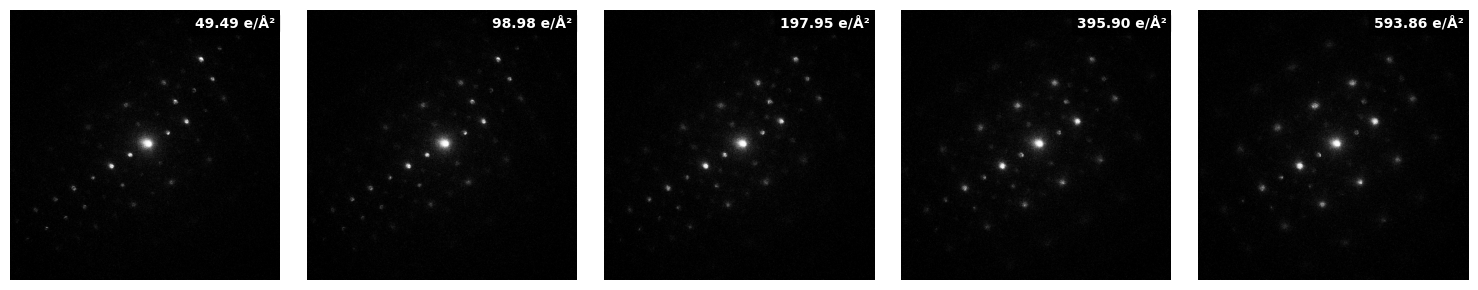

In [33]:
import os

# --- 디렉토리 확인 및 생성 ---
save_dir = "DP_diffraction_series"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# --- 첫 번째 subplot (2행 6열) ---
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    img = summed_images[i]
    dose_text = f"{dose_values[i]:.2f} e/Å²"

    ax.imshow(img, cmap='gray')
    ax.axis("off")

    height, width = img.shape[:2]
    x_pos = width - 60
    y_pos = 80

    ax.text(x_pos, y_pos, dose_text,
            color='white', fontsize=10, weight='bold',
            ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.3'))

for j in range(len(summed_images), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
full_filename = os.path.join(save_dir, f"full_series_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(full_filename, dpi=300, bbox_inches='tight')
plt.show()

# --- 두 번째 subplot (1행 5열) ---
selected_indices = [0, 1, 3, 7, 11]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.flatten()

for ax, idx in zip(axes, selected_indices):
    img = summed_images[idx]
    dose_text = f"{dose_values[idx]:.2f} e/Å²"

    ax.imshow(img, cmap='gray')
    ax.axis("off")

    height, width = img.shape[:2]
    x_pos = width - 60
    y_pos = 80

    ax.text(x_pos, y_pos, dose_text,
            color='white', fontsize=10, weight='bold',
            ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.4, boxstyle='round,pad=0.3'))

plt.tight_layout()
selected_filename = os.path.join(save_dir, f"selected_series_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(selected_filename, dpi=300, bbox_inches='tight')
plt.show()


In [34]:
import json
import os
import re
import ipykernel
import requests



print(f"현재 Jupyter Notebook 파일 이름: {nb_name}")

import pickle

# 파일 이름에서 확장자 (.ipynb) 제거 후 .pkl 파일명으로 설정
pkl_filename = nb_name.replace(".ipynb", ".pkl")

data_to_save = {
    "cumulative_dose": cumulative_dose,
    "normalized_diff": normalize(difference_list_adjusted),
    "highlight_intensities": [0.75, 0.5],
    "difference_list_adjusted": difference_list_adjusted,
    "PbI2_list_adjusted": PbI2_list_adjusted,
    "Perov_list_adjusted": Perov_list_adjusted,
    "Center_list_adjusted": Center_list_adjusted,
    "background_list_adjusted": background_list_adjusted
}

# 저장하기
with open(pkl_filename, "wb") as f:
    pickle.dump(data_to_save, f)

print(f"데이터 저장 완료: {pkl_filename}")

현재 Jupyter Notebook 파일 이름: ROI2-RT-A2
데이터 저장 완료: ROI2-RT-A2


In [35]:
import os
import nbformat
import pickle
import hyperspy.api as hs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cmasher as cmr
import os
import numba
import cv2
from IPython.display import Video
from scipy.optimize import curve_fit
from matplotlib.patches import Rectangle, Circle
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.lines import Line2D


def get_notebook_name():
    """현재 실행 중인 Jupyter Notebook의 파일명을 가져옴"""
    for file in os.listdir():
        if file.endswith(".ipynb"):
            with open(file, "r", encoding="utf-8") as f:
                try:
                    nb_data = nbformat.read(f, as_version=4)
                    if "metadata" in nb_data and "kernelspec" in nb_data["metadata"]:
                        return file
                except Exception:
                    continue
    return "default_notebook.ipynb"  # 찾을 수 없을 때 기본값


print(f"현재 Jupyter Notebook 파일 이름: {nb_name}")

# 저장된 파일 불러오기
with open(nb_name.replace(".ipynb", ".pkl"), "rb") as f:
    loaded_data = pickle.load(f)

cumulative_dose = loaded_data["cumulative_dose"]
normalized_diff = loaded_data["normalized_diff"]
highlight_intensities = loaded_data["highlight_intensities"]
difference_list_adjusted = loaded_data["difference_list_adjusted"]
PbI2_list_adjusted = loaded_data["PbI2_list_adjusted"]
Perov_list_adjusted = loaded_data["Perov_list_adjusted"]
Center_list_adjusted = loaded_data["Center_list_adjusted"]
background_list_adjusted = loaded_data["background_list_adjusted"]

print("데이터 로드 완료 ✅")

# Function to normalize data
def normalize(data):
    first_val = data[0]  # 첫 번째 값
    return [val / first_val for val in data]

# Function to find the closest index for a given value
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

def find_closest_dose(dose_list, intensity_list, target_intensity):
    """
    target_intensity와 가장 가까운 값을 찾고, 해당하는 dose 값을 반환.
    """
    idx = np.abs(np.array(intensity_list) - target_intensity).argmin()
    return dose_list[idx], intensity_list[idx]  # (dose, intensity)

data_lists = [
    (difference_list_adjusted, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]


현재 Jupyter Notebook 파일 이름: ROI2-RT-A2
데이터 로드 완료 ✅


In [36]:
import numpy as np

# 데이터 (예제)
data = np.column_stack((cumulative_dose, normalized_diff))

# # 엑셀 복붙용 출력 (탭으로 구분)
# np.savetxt("output.txt", data, fmt="%.6f", delimiter="\t")  # 소수점 6자리까지 출력

# 파일 없이 바로 콘솔에 출력
for row in data:
    print(f"{row[0]:.6f}\t{row[1]:.6f}")


0.000000	1.000000
3.093000	0.981697
6.186000	0.957440
9.279000	0.993470
12.372000	0.974153
15.465000	1.008593
18.558000	1.011207
21.651000	1.005502
24.744000	1.013313
27.837000	0.946957
30.930000	0.852606
34.023000	0.929481
37.116000	0.927562
40.209000	0.887317
43.302000	1.005072
46.395000	0.945678
49.488000	0.986139
52.581000	0.930552
55.674000	0.857361
58.767000	1.016596
61.860000	0.908239
64.953000	0.989552
68.046000	0.849066
71.139000	0.898384
74.232000	0.889268
77.325000	0.961368
80.418000	0.875485
83.511000	0.929191
86.604000	0.845992
89.697000	0.914005
92.790000	0.922002
95.883000	0.858976
98.976000	0.891370
102.069000	0.835900
105.162000	0.881713
108.255000	0.847505
111.348000	0.872421
114.441000	0.876231
117.534000	0.892923
120.627000	0.909483
123.720000	0.864359
126.813000	0.896866
129.906000	0.897252
132.999000	0.886416
136.092000	0.907865
139.185000	0.898582
142.278000	0.871510
145.371000	0.790917
148.464000	0.909279
151.557000	0.795529
154.650000	0.834239
157.743000	0.9520

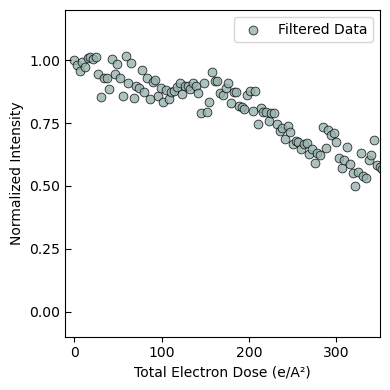

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# NumPy 배열 변환 (모든 데이터)
cumulative_dose = np.array(cumulative_dose)
normalized_diff = np.array(normalized_diff)
PbI2_list_adjusted = np.array(PbI2_list_adjusted)
Perov_list_adjusted = np.array(Perov_list_adjusted)
Center_list_adjusted = np.array(Center_list_adjusted)
background_list_adjusted = np.array(background_list_adjusted)

# 데이터 리스트 (필터링할 모든 데이터)
data_lists = [
    (normalized_diff, "Difference List"),
    (PbI2_list_adjusted, "PbI2 Intensity"),
    (Perov_list_adjusted, "Perovskite Intensity"),
    (Center_list_adjusted, "Center Intensity"),
    (background_list_adjusted, "Background Intensity"),
]

def remove_outliers(x_data, y_data, remove_ranges):
    """
    특정 x 구간의 데이터를 삭제하는 함수.
    
    Parameters:
        x_data (np.array): x축 데이터 (총 전자선량)
        y_data (np.array): y축 데이터 (정규화된 강도)
        remove_ranges (list of tuples): 삭제할 x 구간 리스트 (예: [(200, 220), (300, 320)] )
    
    Returns:
        np.array, np.array: outlier 제거 후의 x_data, y_data
    """
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    mask = np.ones(len(x_data), dtype=bool)  # 전체 데이터를 True로 초기화
    for r in remove_ranges:
        mask &= ~((x_data >= r[0]) & (x_data <= r[1]))  # 해당 구간을 False로 설정
    return x_data[mask], y_data[mask]

# 삭제할 구간 리스트 (두 개의 구간을 삭제)
remove_ranges = [(9999,9999), (9999, 9999)]  

# 모든 데이터 필터링
filtered_cumulative_dose, _ = remove_outliers(cumulative_dose, normalized_diff, remove_ranges)

filtered_results = []
for data, label in data_lists:
    filtered_x, filtered_y = remove_outliers(cumulative_dose, data, remove_ranges)
    filtered_results.append((filtered_x, filtered_y, label))

# 새로운 데이터 플롯
fig, ax = plt.subplots(figsize=(4, 4))

# Difference List 데이터 플롯
ax.scatter(filtered_results[0][0], filtered_results[0][1], label="Filtered Data",
           facecolors="#97B3AE", edgecolors="black", linewidths=0.6,
           alpha=0.8, s=40, marker="o")

ax.set_xlabel("Total Electron Dose (e/A²)")
ax.set_ylabel("Normalized Intensity")
ax.set_ylim(-0.1, 1.2)
ax.set_xlim(-10, 350)
ax.set_yticks(np.arange(0, 1.25, 0.25))  
ax.tick_params(axis='y', direction='in', length=4)  

ax.legend()
plt.tight_layout()
plt.show()


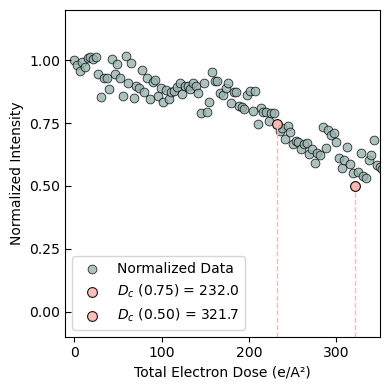

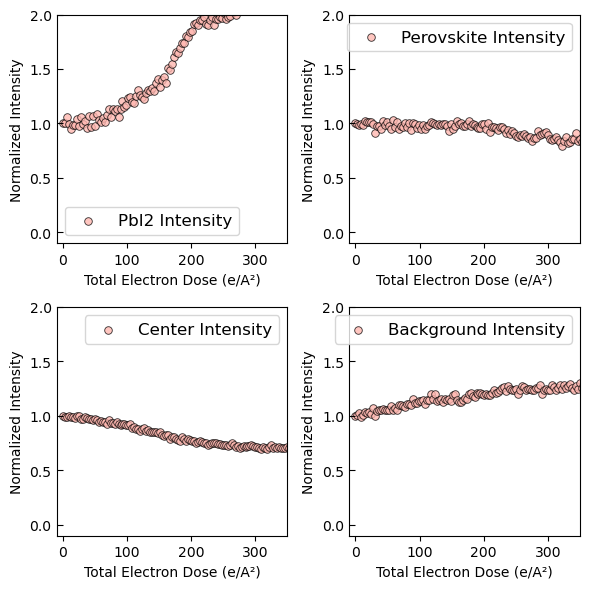

✅ 저장 완료: Graphs_component\components_ROI2-RT-A2.png


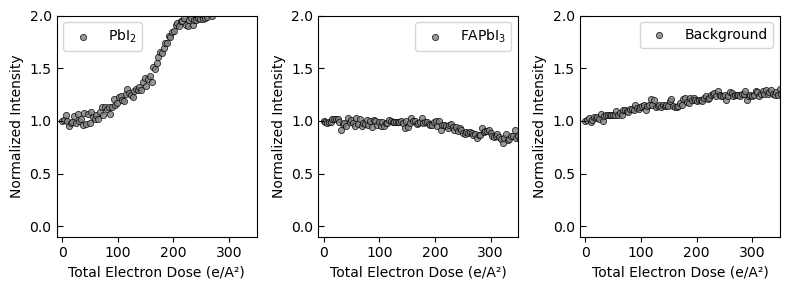

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 📌 Plotting for Difference List (large plot)
fig_diff, ax_diff = plt.subplots(figsize=(4, 4))

# Difference List 데이터 참조 (filtered_results 리스트에서 직접 사용)
ax_diff.scatter(filtered_results[0][0], filtered_results[0][1], label="Normalized Data",
                facecolors="#97B3AE", edgecolors="black", linewidths=0.6,
                alpha=0.8, s=40, marker="o")

ax_diff.set_xlabel("Total Electron Dose (e/A²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)
ax_diff.set_xlim(-10, 350)
ax_diff.set_yticks(np.arange(0, 1.25, 0.25))  # Set y-axis tick interval to 0.25
ax_diff.tick_params(axis='y', direction='in', length=4)  # Set ticks to be inside

# 📌 Highlight specific intensity points (0.75 and 0.5)
for intensity in [0.75, 0.5]:
    dose, value = find_closest_dose(filtered_results[0][0], filtered_results[0][1], intensity)
    ax_diff.scatter(dose, value, color="#FFB8B1", edgecolors="black",
                    linewidths=0.8, alpha=0.9, s=50, marker="o",
                    label=f"$D_{{c}}$ ({value:.2f}) = {dose:.1f}")

    # Add dashed guide lines
    line_x = Line2D([dose, dose], [-0.1, value], color="#FFB8B1", linestyle="--", linewidth=1)
    ax_diff.add_line(line_x)

ax_diff.legend()
plt.tight_layout()
plt.show()

# 📌 Plotting for other datasets (2x2 grid)
fig_others, axes_others = plt.subplots(2, 2, figsize=(6, 6))
axes_others = axes_others.ravel()

for i, (filtered_x, filtered_y, title) in enumerate(filtered_results[1:]):  # Difference List 제외
    normalized_data = normalize(filtered_y)  # Normalize the data
    axes_others[i].scatter(filtered_x, normalized_data, label=title,
                           facecolors="#FFB8B1", edgecolors="black", linewidths=0.6,
                           alpha=0.8, s=30, marker="o")

    axes_others[i].set_xlabel("Total Electron Dose (e/A²)")
    axes_others[i].set_ylabel("Normalized Intensity")
    axes_others[i].set_ylim(-0.1, 2.0)
    axes_others[i].set_xlim(-10, 350)
    axes_others[i].legend(fontsize=12)
    axes_others[i].tick_params(axis='y', direction='in', length=4)  # Set ticks to be inside

# Hide the empty subplot if any
if len(filtered_results[1:]) < len(axes_others):
    axes_others[-1].axis("off")

plt.tight_layout()
plt.show()


# 📌 Plotting PbI2, FAPbI3, Background Intensity Only (1x3)
fig_selected, axes_selected = plt.subplots(1, 3, figsize=(8, 3))

# 변경된 label 명
legend_labels = ["PbI$_2$", "FAPbI$_3$", "Background"]
selected_indices = [1, 2, 4]  # filtered_results의 해당 index

for ax, idx, label in zip(axes_selected, selected_indices, legend_labels):
    filtered_x, filtered_y, _ = filtered_results[idx]
    normalized_y = normalize(filtered_y)

    ax.scatter(filtered_x, normalized_y, label=label,
               facecolors="gray", edgecolors="black", linewidths=0.6,
               alpha=0.8, s=20, marker="o")

    ax.set_xlabel("Total Electron Dose (e/A²)")
    ax.set_ylabel("Normalized Intensity")
    ax.set_ylim(-0.1, 2.0)
    ax.set_xlim(-10, 350)
    ax.tick_params(axis='y', direction='in', length=4)
    ax.legend(fontsize=10)

plt.tight_layout()

# --- 디렉토리 생성 및 저장 ---
save_dir = "Graphs_component"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, f"components_{nb_name.replace('.ipynb', '')}.png")
plt.savefig(save_path, dpi=300)
print(f"✅ 저장 완료: {save_path}")

plt.show()


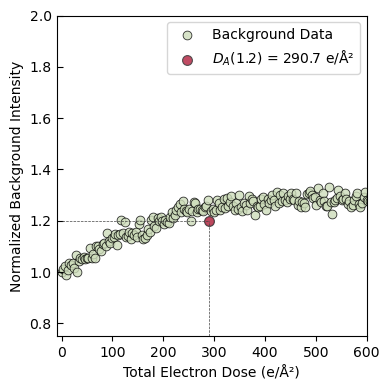

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import csv

# --- 데이터 준비 ---
background_intensity = np.array(data_lists[4][0])
total_electron_dose = np.array(cumulative_dose)
normalized_background = np.array(normalize(background_intensity))

# --- y=1.2에 가장 가까운 값 찾기 ---
target_y = 1.2
differences = np.abs(normalized_background - target_y)
min_index = np.argmin(differences)
Da_val = total_electron_dose[min_index]
highlight_y = normalized_background[min_index]

# --- 시각화 ---
fig_background, ax_background = plt.subplots(figsize=(4, 4))
ax_background.scatter(total_electron_dose, normalized_background, label="Background Data",
                      facecolors="#CEDDBB", edgecolors="black", linewidths=0.6,
                      alpha=0.8, s=40, marker="o")

# 하이라이트된 D_A 지점 표시
ax_background.scatter(Da_val, highlight_y, color="#B93752", edgecolors="#434343",
                      linewidths=0.8, alpha=0.9, s=50, marker="o",
                      label=f"$D_A$(1.2) = {Da_val:.1f} e/Å²")

# 점선 안내선
ax_background.add_line(Line2D([Da_val, Da_val], [0.75, highlight_y], color="#434343", linestyle="--", linewidth=0.5))
ax_background.add_line(Line2D([0, Da_val], [highlight_y, highlight_y], color="#434343", linestyle="--", linewidth=0.5))

# Plot 설정
ax_background.set_xlabel("Total Electron Dose (e/Å²)")
ax_background.set_ylabel("Normalized Background Intensity")
ax_background.set_ylim(0.75, 2.0)
ax_background.set_xlim(-10, 600)
ax_background.legend()
ax_background.tick_params(axis='y', direction='in', length=4)
plt.tight_layout()

# --- 이미지 저장 ---
save_dir = "Graphs_background_collections"
os.makedirs(save_dir, exist_ok=True)
nb_base = os.path.splitext(nb_name)[0]
image_path = os.path.join(save_dir, f"{nb_base}_background_nearest_to_1.2.png")
plt.savefig(image_path, dpi=300)
plt.show()

# --- D_A 값 저장 ---
csv_path = "background_DA.csv"
header = ["index", "D_A"]

file_exists = os.path.isfile(csv_path)
with open(csv_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(header)
    writer.writerow([nb_base, f"{Da_val:.1f}"])


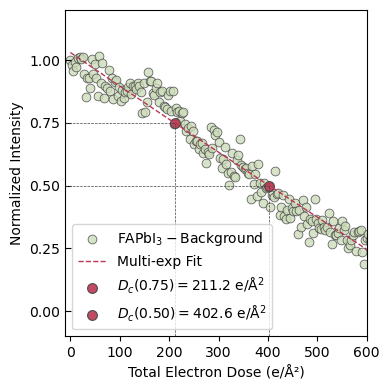

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
import os
import csv

# 📌 다중 지수 함수 정의
def multi_exp_fit(x, a1, b1, a2, b2, c):
    return a1 * np.exp(-b1 * x) + a2 * np.exp(-b2 * x) + c

# 📌 Difference List 데이터 준비
filtered_cumulative_dose, filtered_normalized_diff, _ = filtered_results[0]

# 📌 NaN/Inf 제거
valid_indices = ~(np.isnan(filtered_cumulative_dose) | np.isnan(filtered_normalized_diff) | 
                  np.isinf(filtered_cumulative_dose) | np.isinf(filtered_normalized_diff))
filtered_cumulative_dose = filtered_cumulative_dose[valid_indices]
filtered_normalized_diff = filtered_normalized_diff[valid_indices]

# 📌 커브 피팅
try:
    popt, _ = curve_fit(multi_exp_fit, filtered_cumulative_dose, filtered_normalized_diff, 
                        p0=[2, 0.005, 1, 0.0005, 0], maxfev=1000000)
except RuntimeError as e:
    print(f"Curve fitting failed: {e}")
    popt = [np.nan] * 5

# 📌 피팅 곡선
x_fit = np.linspace(min(filtered_cumulative_dose), max(filtered_cumulative_dose), 500)
y_fit = multi_exp_fit(x_fit, *popt) if not np.isnan(popt[0]) else np.full_like(x_fit, np.nan)

# 📌 Dc 계산
Dc_values = {}
if not np.isnan(popt[0]):
    for intensity in [0.75, 0.5]:
        dose = np.interp(intensity, y_fit[::-1], x_fit[::-1])
        Dc_values[intensity] = dose

# 📌 플롯
fig_diff, ax_diff = plt.subplots(figsize=(4, 4))
ax_diff.scatter(filtered_cumulative_dose, filtered_normalized_diff, 
                label=r"$\mathrm{FAPbI}_3 - \mathrm{Background}$",
                facecolors="#CEDDBB", edgecolors="#434343", linewidths=0.6,
                alpha=0.8, s=40, marker="o")

if not np.isnan(popt[0]):
    ax_diff.plot(x_fit, y_fit, color="#B93752", linestyle="--", linewidth=1.0, label="Multi-exp Fit")

# 축 설정
ax_diff.set_xlabel("Total Electron Dose (e/Å²)")
ax_diff.set_ylabel("Normalized Intensity")
ax_diff.set_ylim(-0.1, 1.2)
ax_diff.set_xlim(-10, 600)
ax_diff.set_yticks(np.arange(0, 1.25, 0.25))
ax_diff.tick_params(axis='y', direction='in', length=4)

# 하이라이트 및 점선
if Dc_values:
    for intensity, dose in Dc_values.items():
        value = multi_exp_fit(dose, *popt)
        ax_diff.scatter(dose, value, color="#B93752", edgecolors="#434343",
                        linewidths=0.8, alpha=0.9, s=50, marker="o",
                        label = fr"$D_{{c}}({intensity:.2f}) = {dose:.1f}\ \mathrm{{e}}/\mathrm{{\AA}}^2$")
        ax_diff.add_line(Line2D([dose, dose], [-0.1, value], color="#434343", linestyle="--", linewidth=0.5))
        ax_diff.add_line(Line2D([-10, dose], [value, value], color="#434343", linestyle="--", linewidth=0.5))

ax_diff.legend()
plt.tight_layout()
plt.show()

# 📌 이미지 저장
save_dir = "Graphs_difference_collection"
os.makedirs(save_dir, exist_ok=True)
nb_base = os.path.splitext(nb_name)[0]  # 예: ROI1-200K-A17
image_path = os.path.join(save_dir, f"{nb_base}_difference_fit.png")
fig_diff.savefig(image_path, dpi=300)

# 📌 CSV 저장
csv_path = "difference_DC.csv"
header = ["index", "D_C(0.75)", "D_C(0.50)"]
file_exists = os.path.isfile(csv_path)

with open(csv_path, mode='a', newline='') as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(header)
    dc_075 = f"{Dc_values.get(0.75, 'NaN'):.1f}" if 0.75 in Dc_values else "NaN"
    dc_050 = f"{Dc_values.get(0.5, 'NaN'):.1f}" if 0.5 in Dc_values else "NaN"
    writer.writerow([nb_base, dc_075, dc_050])

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
# import os
# import csv

# # 📌 Difference List 데이터 준비
# filtered_cumulative_dose, filtered_normalized_diff, _ = filtered_results[0]

# # 📌 NaN/Inf 제거
# valid_indices = ~(np.isnan(filtered_cumulative_dose) | np.isnan(filtered_normalized_diff) | 
#                   np.isinf(filtered_cumulative_dose) | np.isinf(filtered_normalized_diff))
# filtered_cumulative_dose = filtered_cumulative_dose[valid_indices]
# filtered_normalized_diff = filtered_normalized_diff[valid_indices]

# # 📌 Dc 계산 (피팅 없이 직접 검색)
# Dc_values = {}
# for target_y in [0.75, 0.5]:
#     differences = np.abs(filtered_normalized_diff - target_y)
#     min_index = np.argmin(differences)
#     Dc_values[target_y] = filtered_cumulative_dose[min_index]

# # 📌 플롯
# fig_diff, ax_diff = plt.subplots(figsize=(4, 4))
# ax_diff.scatter(filtered_cumulative_dose, filtered_normalized_diff, 
#                 label=r"$\mathrm{FAPbI}_3 - \mathrm{Background}$",
#                 facecolors="#CEDDBB", edgecolors="#434343", linewidths=0.6,
#                 alpha=0.8, s=40, marker="o")

# # 하이라이트 및 점선
# for intensity, dose in Dc_values.items():
#     value = filtered_normalized_diff[np.argmin(np.abs(filtered_normalized_diff - intensity))]
#     ax_diff.scatter(dose, value, color="#B93752", edgecolors="#434343",
#                     linewidths=0.8, alpha=0.9, s=50, marker="o",
#                     label = fr"$D_{{c}}({intensity:.2f}) = {dose:.1f}\ \mathrm{{e}}/\mathrm{{\AA}}^2$")
#     ax_diff.add_line(Line2D([dose, dose], [-0.1, value], color="#434343", linestyle="--", linewidth=0.5))
#     ax_diff.add_line(Line2D([-10, dose], [value, value], color="#434343", linestyle="--", linewidth=0.5))

# # 축 설정
# ax_diff.set_xlabel("Total Electron Dose (e/Å²)")
# ax_diff.set_ylabel("Normalized Intensity")
# ax_diff.set_ylim(-0.1, 1.2)
# ax_diff.set_xlim(-10, 600)
# ax_diff.set_yticks(np.arange(0, 1.25, 0.25))
# ax_diff.tick_params(axis='y', direction='in', length=4)
# ax_diff.legend()
# plt.tight_layout()
# plt.show()

# # 📌 이미지 저장
# save_dir = "Graphs_difference_collection"
# os.makedirs(save_dir, exist_ok=True)
# nb_base = os.path.splitext(nb_name)[0]  # 예: ROI1-200K-A17
# image_path = os.path.join(save_dir, f"{nb_base}_difference_closest.png")
# fig_diff.savefig(image_path, dpi=300)

# # 📌 CSV 저장
# csv_path = "difference_DC.csv"
# header = ["index", "D_C(0.75)", "D_C(0.50)"]
# file_exists = os.path.isfile(csv_path)

# with open(csv_path, mode='a', newline='') as f:
#     writer = csv.writer(f)
#     if not file_exists:
#         writer.writerow(header)
#     dc_075 = f"{Dc_values.get(0.75, 'NaN'):.1f}" if 0.75 in Dc_values else "NaN"
#     dc_050 = f"{Dc_values.get(0.5, 'NaN'):.1f}" if 0.5 in Dc_values else "NaN"
#     writer.writerow([nb_base, dc_075, dc_050])
